## 03 - Evaluate HPCS-derived traced cells
Combine data from IGO15600, IGO15601, IGO15771, and IGO15488(1_2) to evaluate HPCS-derived cells

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from joblib import dump, load

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_90069/3120779465.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
#plt.rcParams['figure.figsize'] = (3,4)

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [4]:
Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

## Define scoring Functions

In [5]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [6]:
(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [7]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [8]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

## Define cells to be only traced cells for PV calculation

In [9]:
adata = load('write/combined_data.joblib')

In [10]:
#Ensure PV is using only same variables across all cells and batches
non_zero_vars = adata.var_names[np.all(adata.X != 0, axis=0)]
adata = adata[:, non_zero_vars]
adata = adata[:, adata.var.highly_variable]

In [11]:
#Phenotypic Volume
def calcPV(matrix):
    gene_cov = np.cov(matrix.T)
    mat = pd.DataFrame(gene_cov)
    eig_vals = np.linalg.eigvalsh(mat)
    return(sum(np.log2(eig_vals[eig_vals > 0])))

In [12]:
#uncomment if you want to generate data for Fig 2e

## 14 wk PV

In [13]:
from scipy.stats import mannwhitneyu

In [14]:
repeats = 1000

In [15]:
matrix = adata[adata.obs['cell type'].isin(['HPCS']) & adata.obs['Group'].isin(['14wk']),adata.var['highly_variable']].X.copy()
dist1 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist1.append(calcPV(matrix[sample_id]))

In [16]:
matrix = adata[adata.obs['Group'].isin(['14wk']),adata.var['highly_variable']].X.copy()
dist2 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist2.append(calcPV(matrix[sample_id]))

In [17]:
matrix = adata[adata.obs['batch'].isin(['untraced_14wk']),adata.var['highly_variable']].X.copy()
dist3 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist3.append(calcPV(matrix[sample_id]))

In [18]:
print(sum(dist1)/len(dist1), sum(dist2)/len(dist2), sum(dist3)/len(dist3))

-23114.70444096707 -21640.588332447092 -22013.912172870776


In [19]:
mannwhitneyu(dist1, dist2)

MannwhitneyuResult(statistic=97.0, pvalue=0.0)

In [20]:
mannwhitneyu(dist1, dist3)

MannwhitneyuResult(statistic=7009.0, pvalue=0.0)

In [21]:
mannwhitneyu(dist2, dist3)

MannwhitneyuResult(statistic=850280.0, pvalue=4.893574103726814e-162)

In [22]:
pd.DataFrame(np.column_stack((dist1, dist2,dist3)),columns=['HPCS@14wk','All@14wk','Untraced@14wk']).to_excel('figures/Fig2e_PV_hpcs_14wk_combined.xlsx')

## 8 wk PV

In [23]:
matrix = adata[adata.obs['cell type'].isin(['HPCS']) & adata.obs['Group'].isin(['8wk']),adata.var['highly_variable']].X.copy()
dist1 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist1.append(calcPV(matrix[sample_id]))

In [24]:
matrix = adata[adata.obs['Group'].isin(['8wk']),adata.var['highly_variable']].X.copy()
dist2 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist2.append(calcPV(matrix[sample_id]))

In [25]:
print(sum(dist1)/len(dist1), sum(dist2)/len(dist2))

-23222.971485306618 -21713.498434251123


In [26]:
pd.DataFrame(np.column_stack((dist1, dist2)),columns=['HPCS@8wk','All@8wk']).to_excel('figures/Fig2e_PV_hpcs_8wk_combined.xlsx')

## Reload only traced cells

In [27]:
adata = load('write/combined_data.joblib')

In [28]:
adata.obs[['batch','Group']].value_counts(sort=False)

batch          Group 
traced         8wk         742
               14wk        991
depletion      Saline    10763
untraced_14wk  KPT        1865
Name: count, dtype: int64

In [29]:
alladata = adata
#adata2 = alladata[alladata.obs.batch.isin(['traced','untraced_14wk']),:].copy()
adata = adata[adata.obs.batch.isin(['traced']),:].copy()

## Explore Data

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


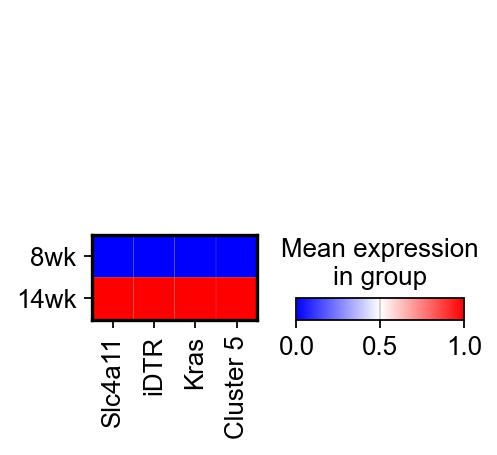

In [30]:
sc.pl.matrixplot(adata,['Slc4a11','iDTR','Kras','Cluster 5'],'Group',cmap='bwr', standard_scale='var')

## Examine Groupings

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


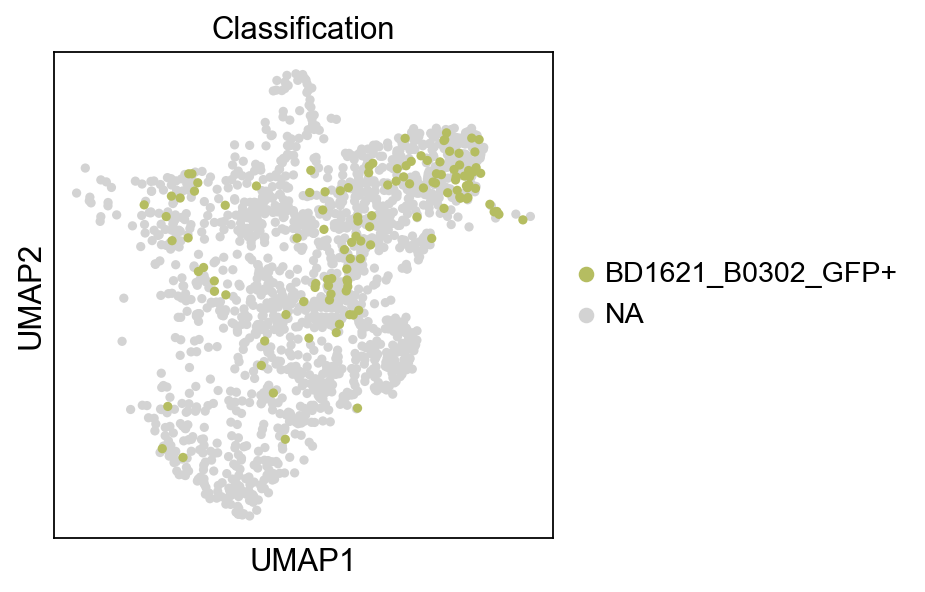

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


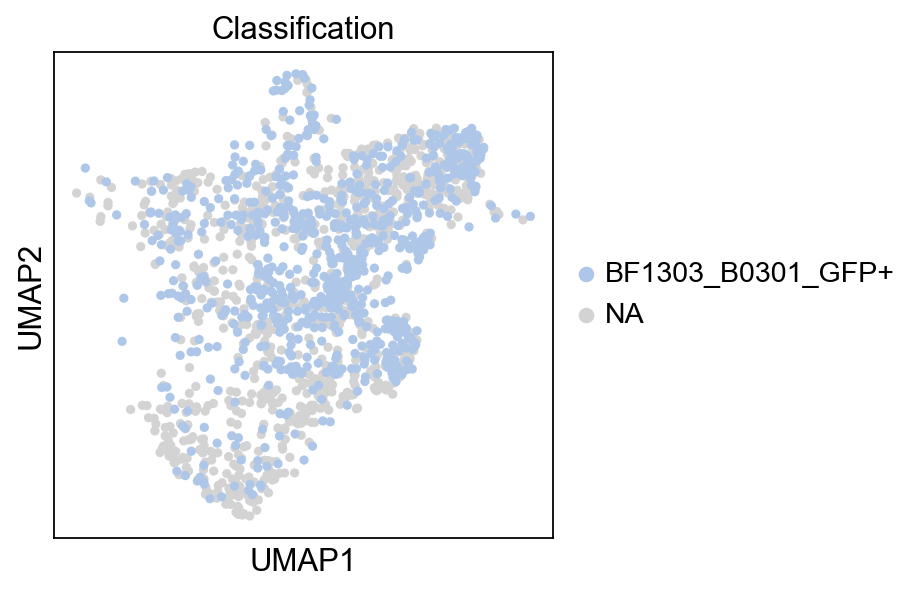

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


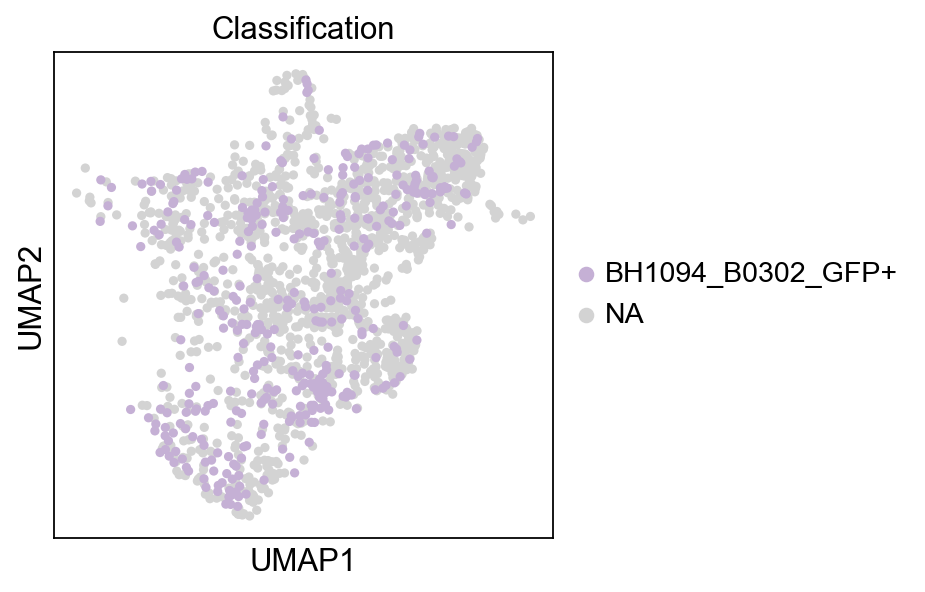

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


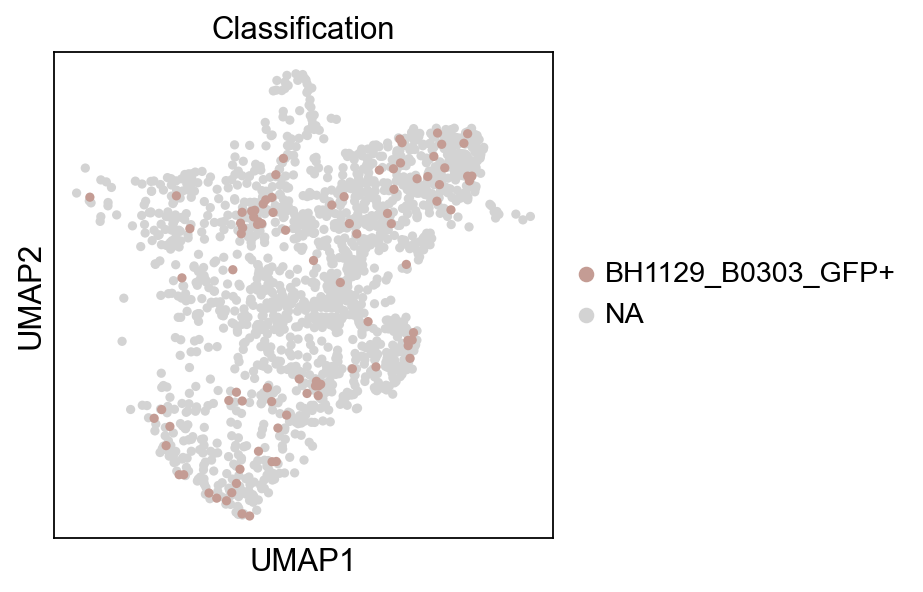

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


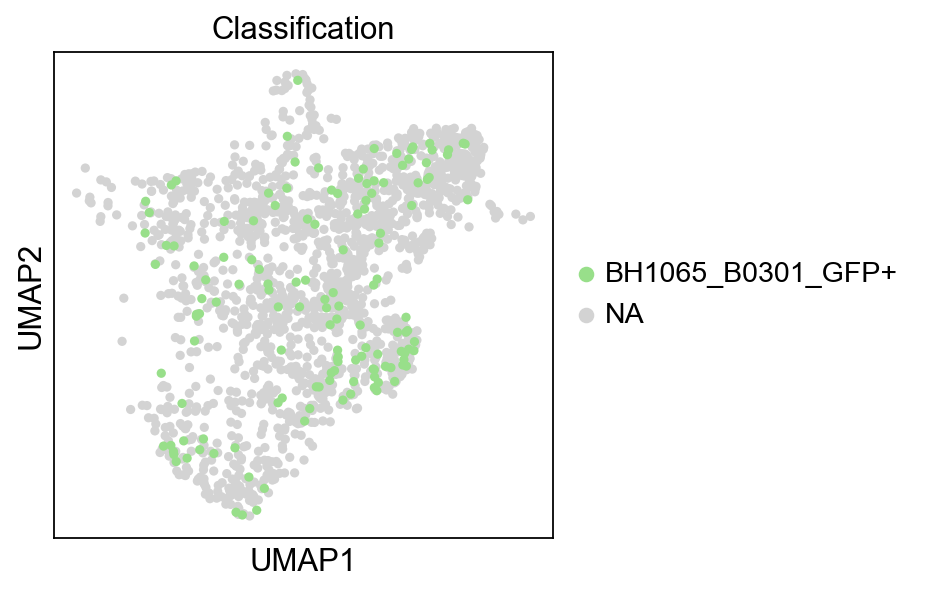

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


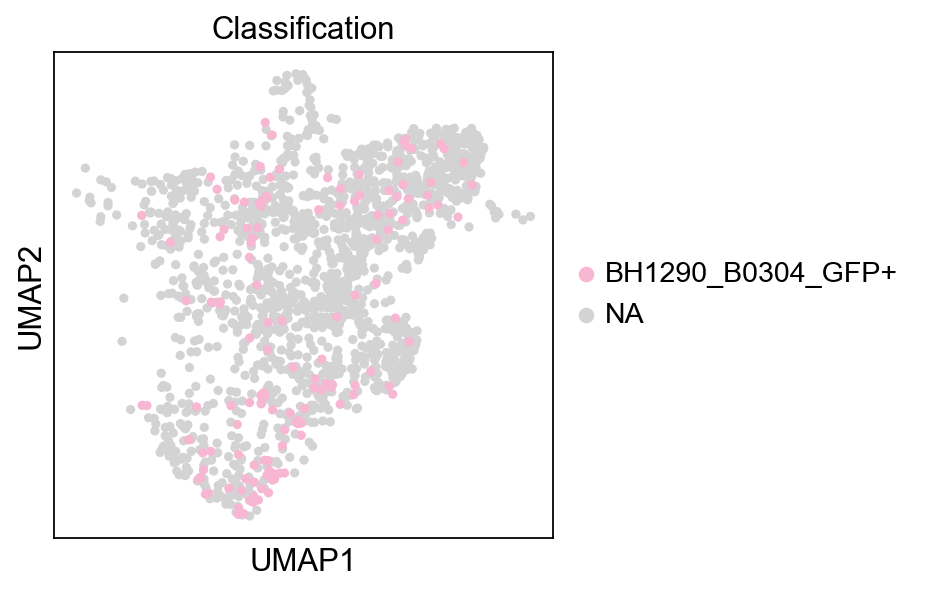

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


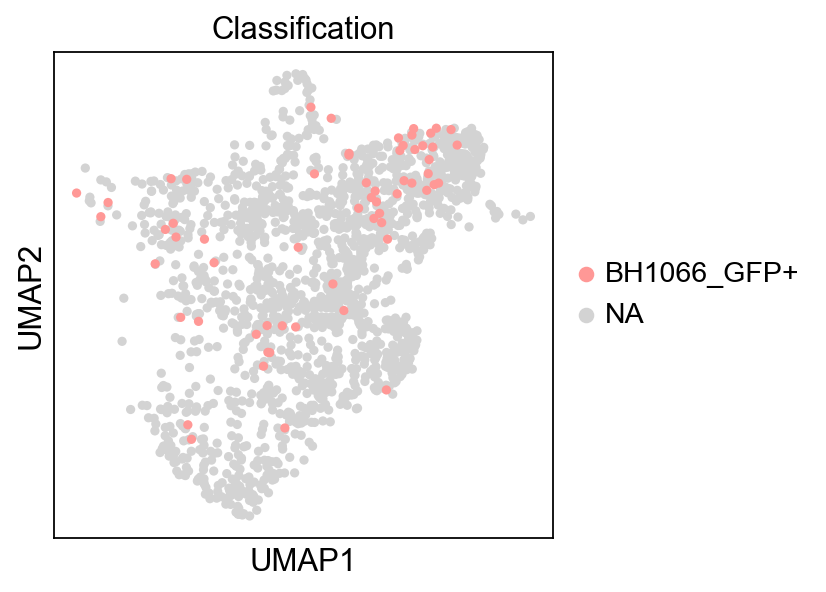

In [31]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

In [32]:
sc.tl.embedding_density(adata,basis='umap', groupby='batch')

computing density on 'umap'
--> added
    'umap_density_batch', densities (adata.obs)
    'umap_density_batch_params', parameter (adata.uns)


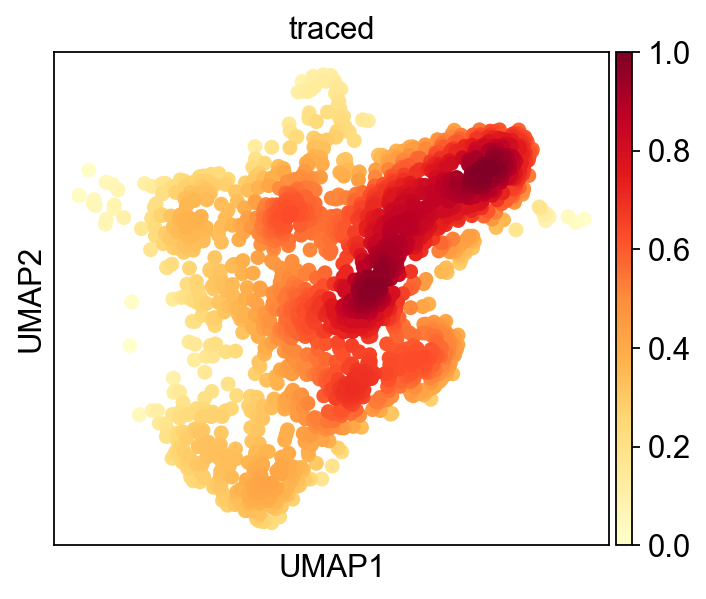

In [33]:
sc.pl.embedding_density(adata,basis='umap',key='umap_density_batch', )

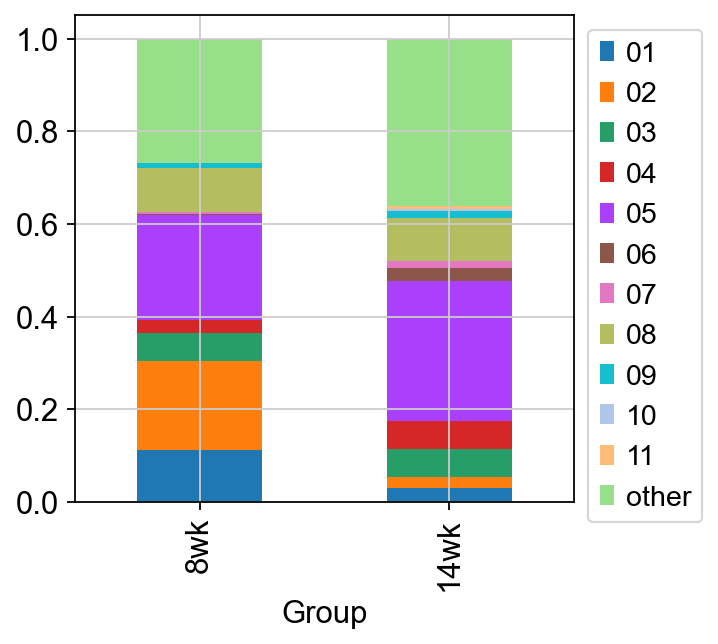

In [34]:
 cell_proportion_df = pd.crosstab(adata.obs['clusterK12_stringent'],adata.obs['Group'], normalize='columns').T.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1,1))

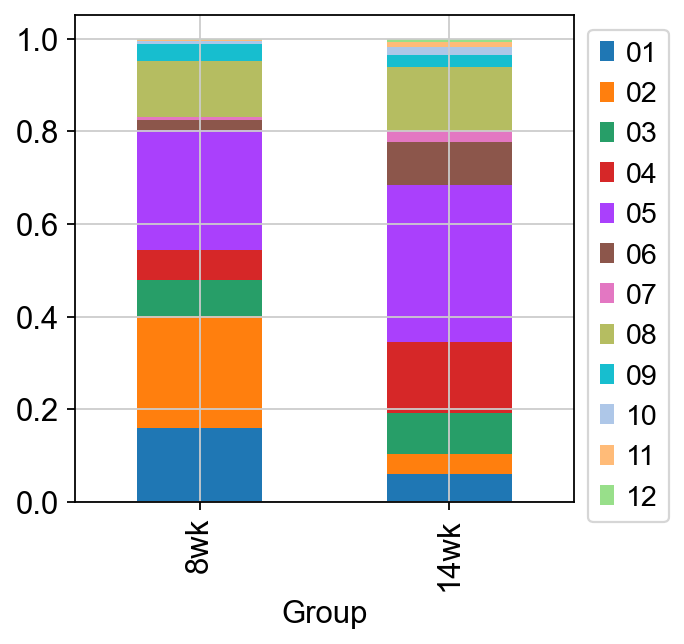

In [35]:
 cell_proportion_df = pd.crosstab(adata.obs['clusterK12'],adata.obs['Group'], normalize='columns').T.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1,1))

In [36]:
adata.obs[['Group','Classification']].value_counts(sort=False)

Group  Classification   
8wk    BH1065_B0301_GFP+    138
       BH1094_B0302_GFP+    376
       BH1129_B0303_GFP+     90
       BH1290_B0304_GFP+    138
14wk   BD1621_B0302_GFP+    119
       BF1303_B0301_GFP+    811
       BH1066_GFP+           61
Name: count, dtype: int64

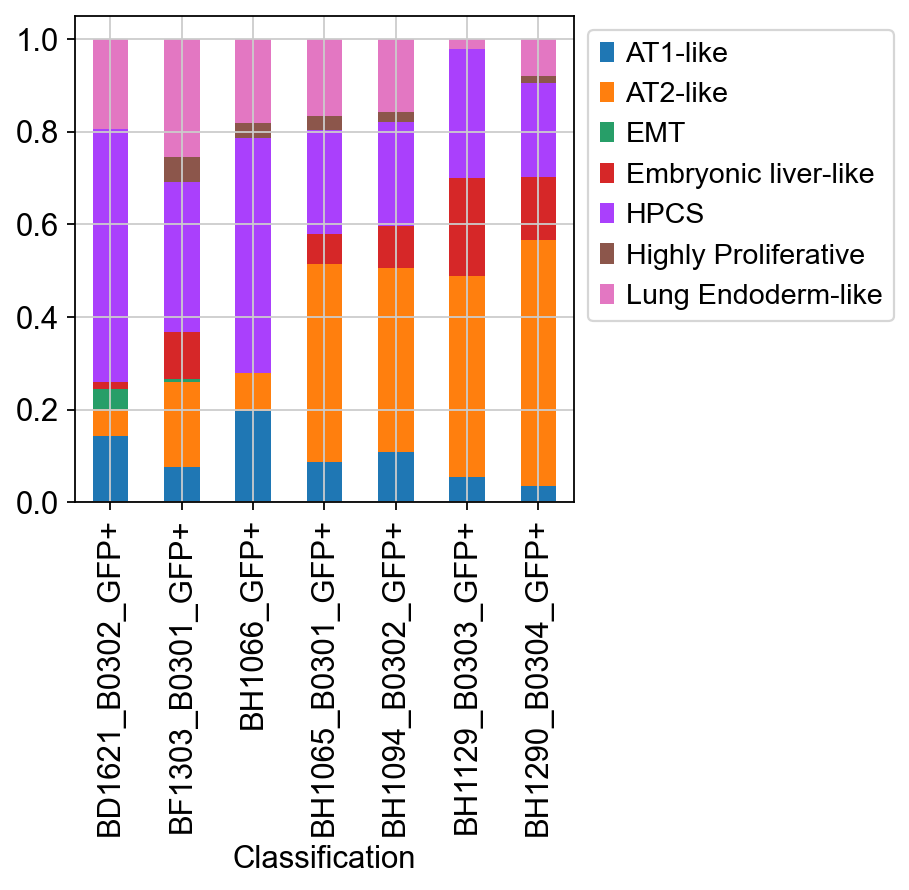

In [37]:
ordered = ['BD1621_B0302_GFP+','BF1303_B0301_GFP+','BH1066_GFP+','BH1065_B0301_GFP+','BH1094_B0302_GFP+','BH1129_B0303_GFP+','BH1290_B0304_GFP+']
cell_proportion_df = pd.crosstab(adata.obs['cell type'],adata.obs['Classification'], normalize='columns')[ordered].T.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1,1))

In [38]:
sc.tl.embedding_density(adata,basis='umap', groupby='Classification')

computing density on 'umap'
--> added
    'umap_density_Classification', densities (adata.obs)
    'umap_density_Classification_params', parameter (adata.uns)


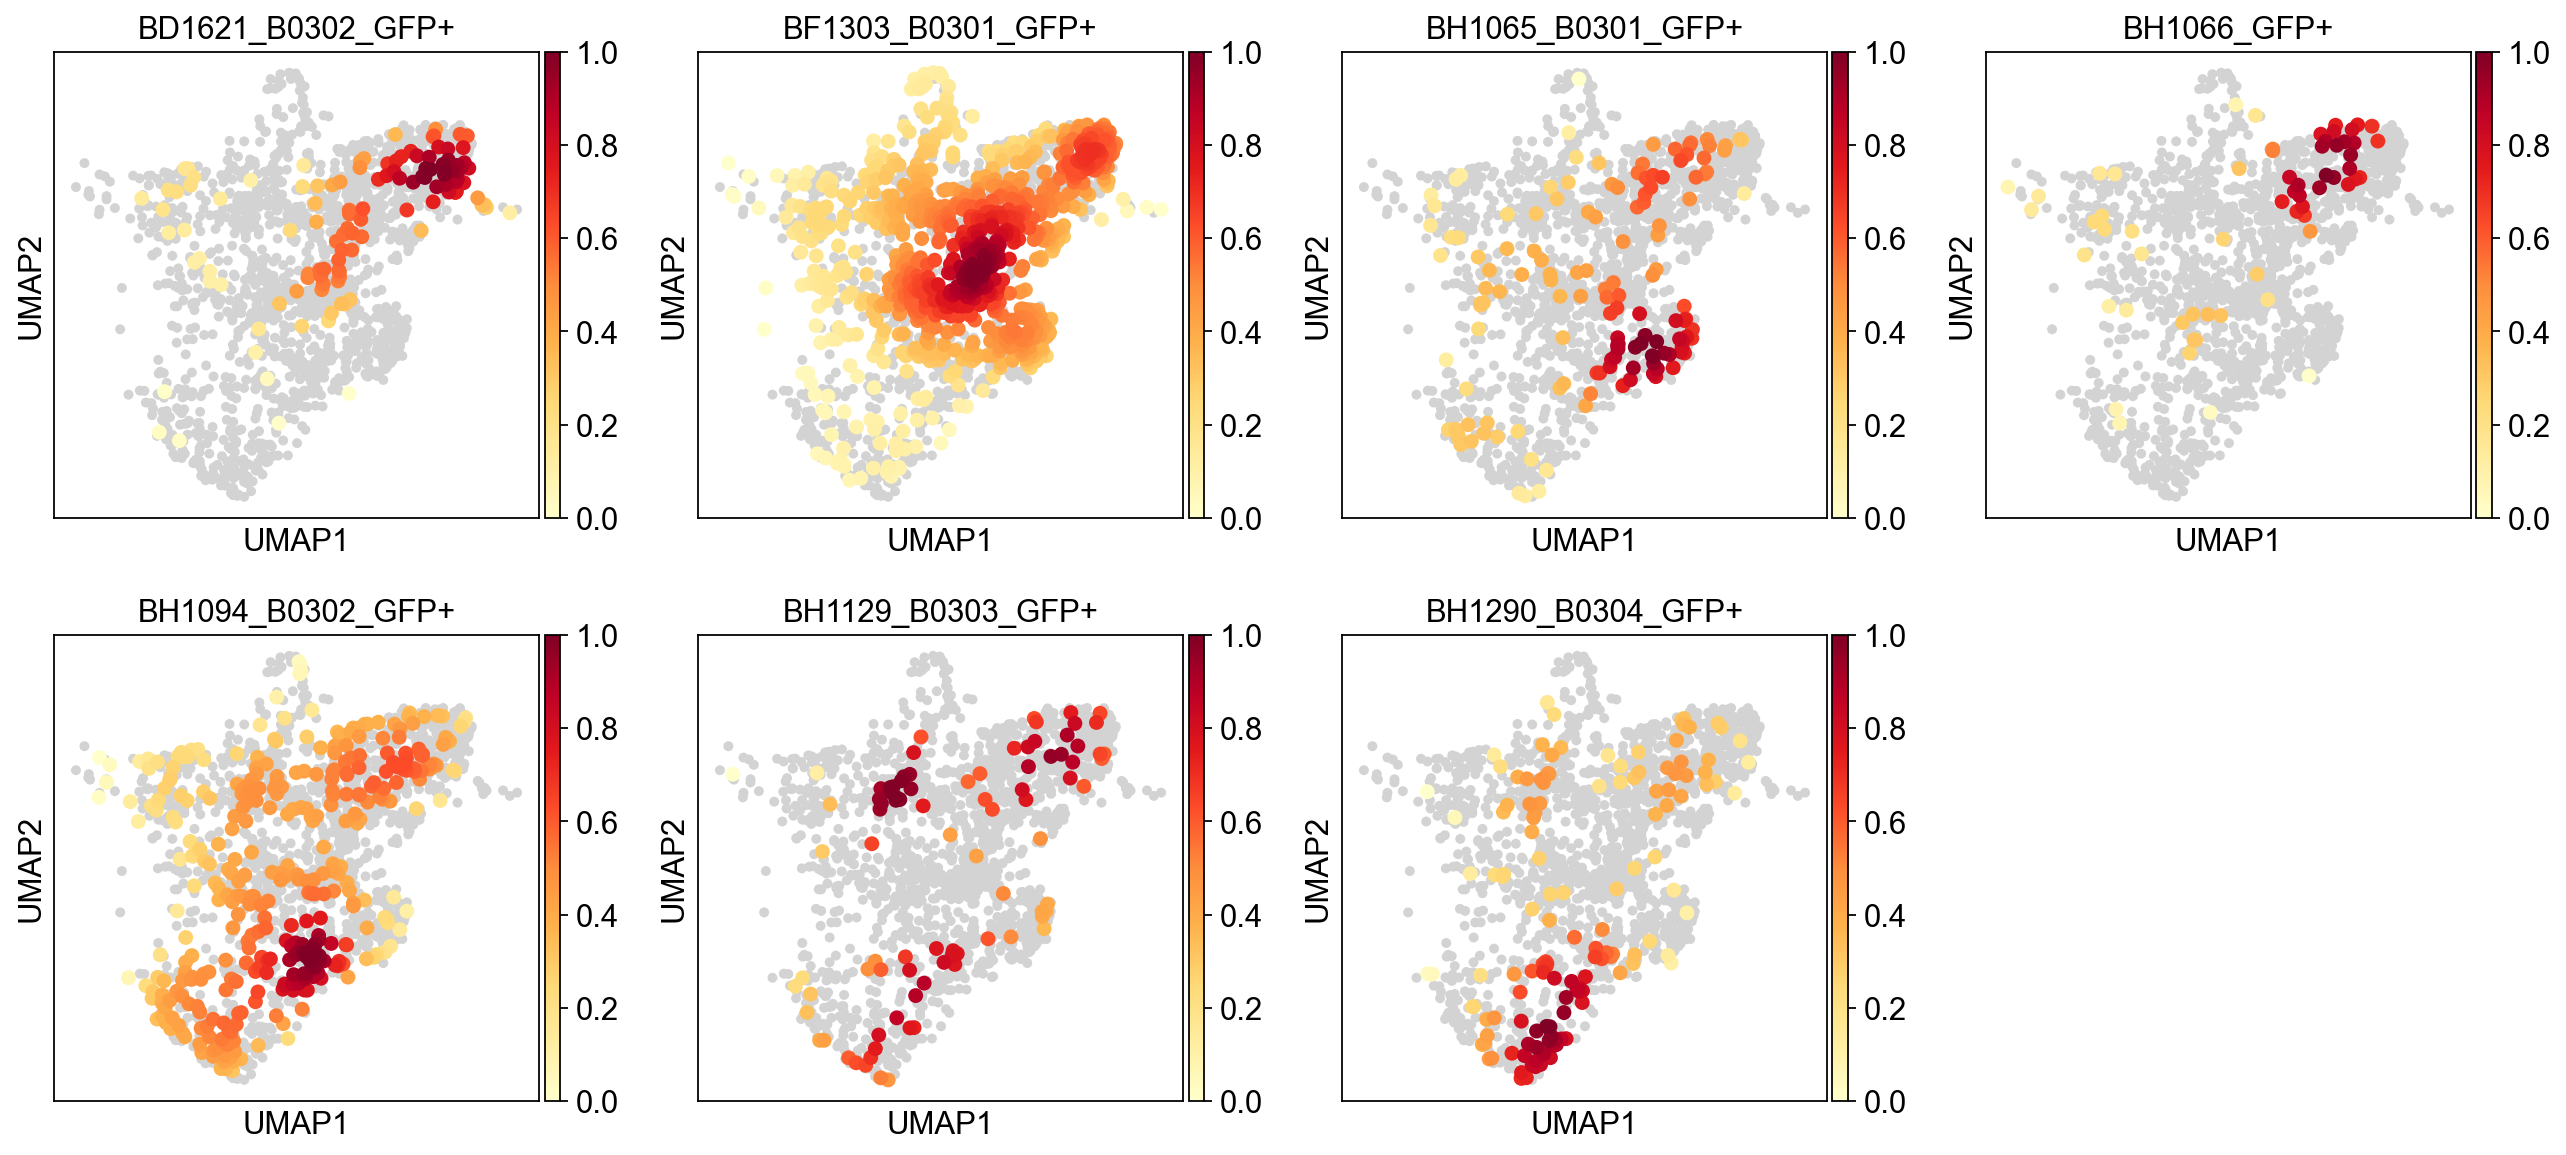

In [39]:
sc.pl.embedding_density(adata,basis='umap',key='umap_density_Classification')

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


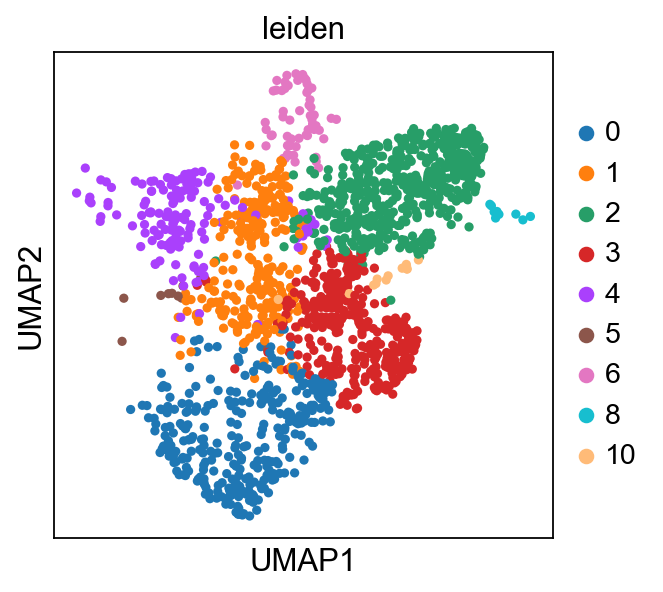

In [40]:
sc.pl.umap(adata, color=['leiden'])

## Evaluate rough clusters

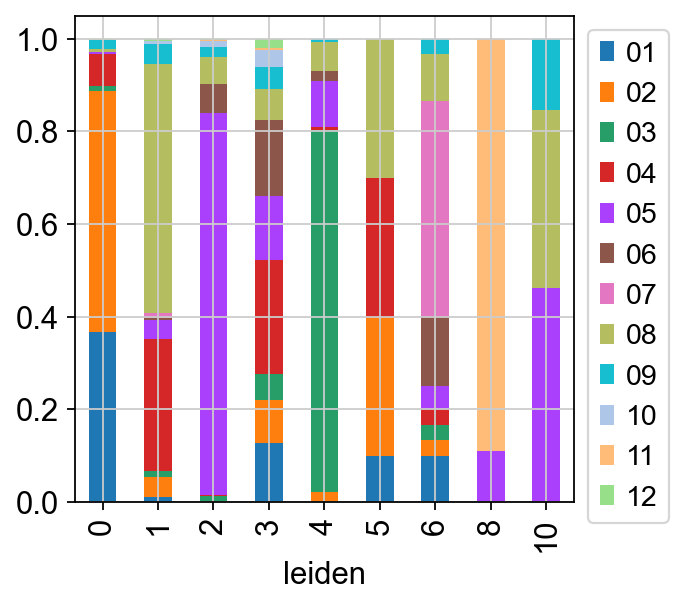

In [41]:
 cell_proportion_df = pd.crosstab(adata.obs['clusterK12'],adata.obs['leiden'], normalize='columns').T.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1,1))

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


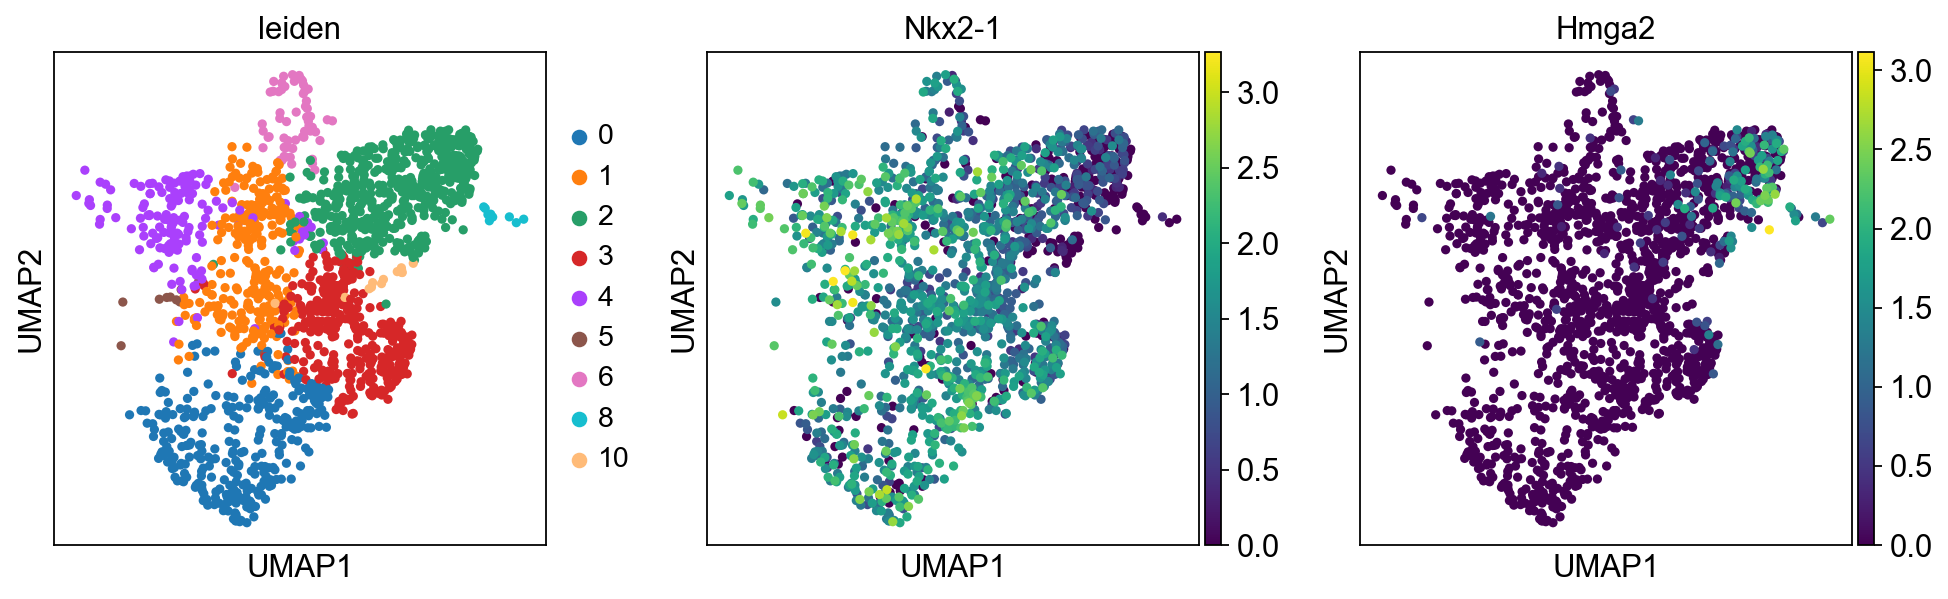

In [42]:
sc.pl.umap(adata, color=['leiden','Nkx2-1','Hmga2'])

## Figures for the paper

### Generate bar graph figures

In [43]:
adata2 = adata[adata.obs.Group.isin(['14wk']),:]

In [44]:
adata2.obs['HPCS_cell'] = [1  if x == 'HPCS' else 0 for x in adata2.obs['cell type']]

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_90069/309636913.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['HPCS_cell'] = [1  if x == 'HPCS' else 0 for x in adata2.obs['cell type']]


In [45]:
adata3 = adata[adata.obs.Group.isin(['8wk']),:]

In [46]:
adata3.obs['HPCS_cell'] = [1  if x == 'HPCS' else 0 for x in adata3.obs['cell type']]

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_90069/1242395224.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata3.obs['HPCS_cell'] = [1  if x == 'HPCS' else 0 for x in adata3.obs['cell type']]


#### 14 week timepoints

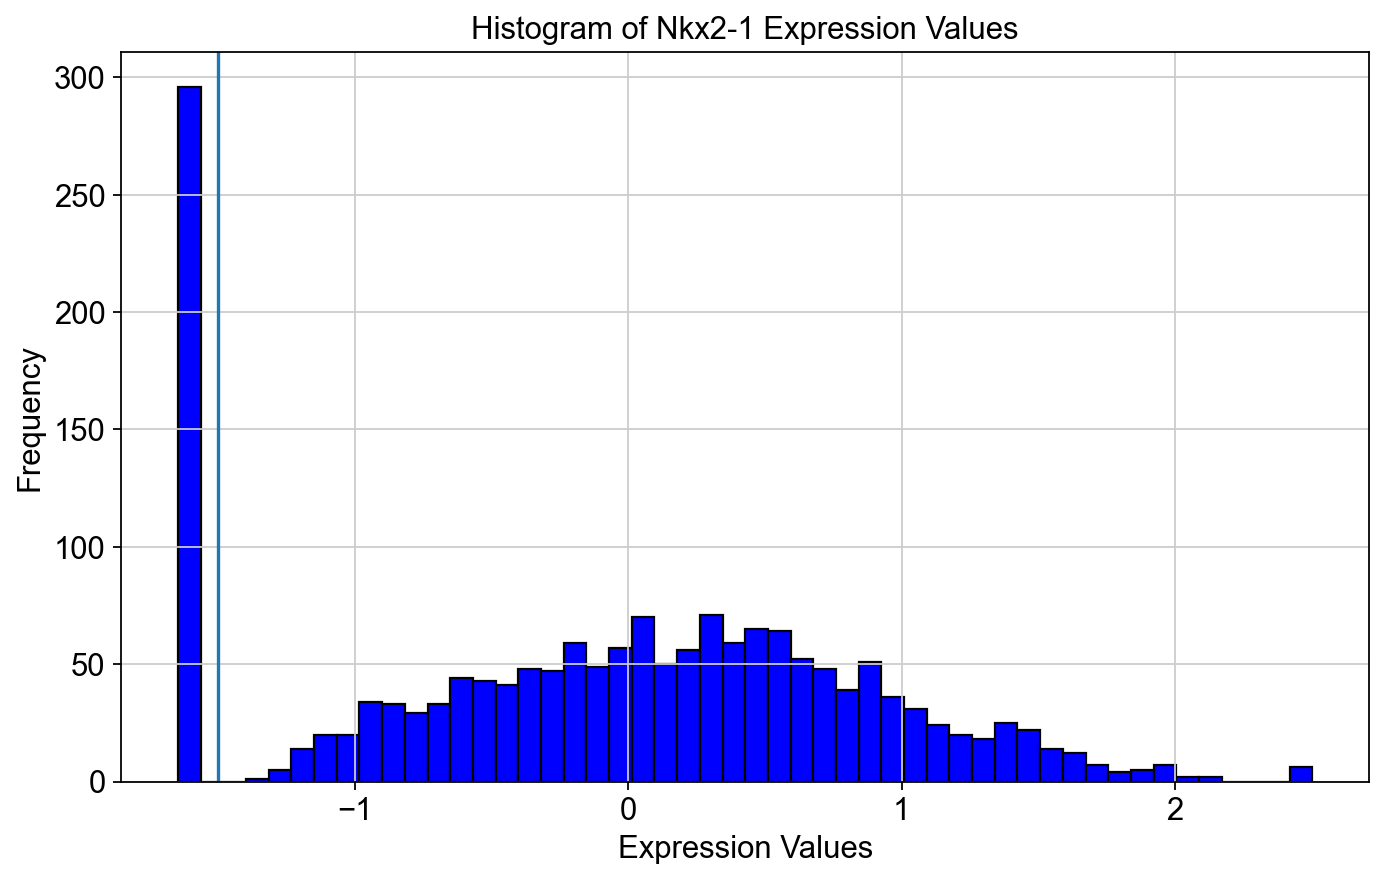

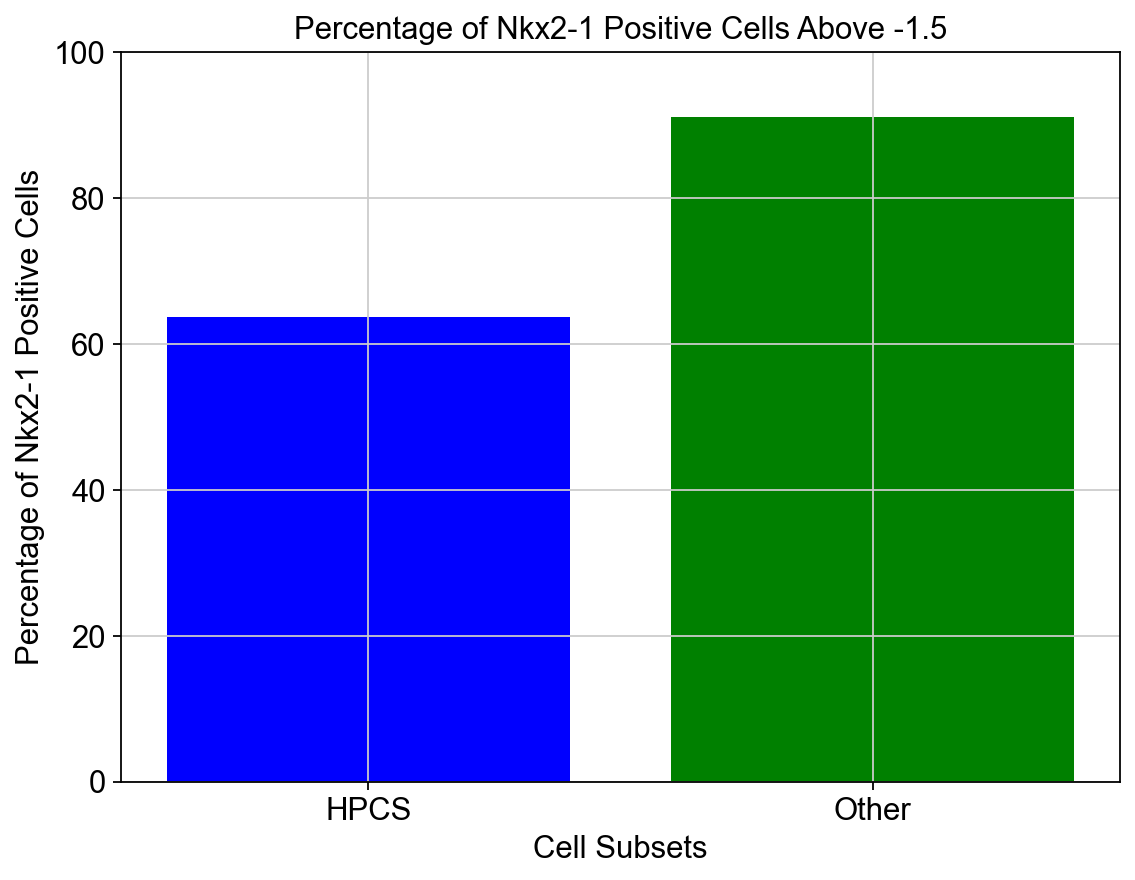

SignificanceResult(statistic=0.17021730435941873, pvalue=2.177331152587983e-25)

In [47]:
gene = 'Nkx2-1'
expression_values = adata[:, gene].X
threshold = -1.5

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata2[adata2.obs['HPCS_cell'] == 1,:]
subset_b = adata2[adata2.obs['HPCS_cell'] == 0,:]

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Fig2i_{gene}_positive_cells_percentage_14wk.svg')
plt.show()

# calculate statistics
from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

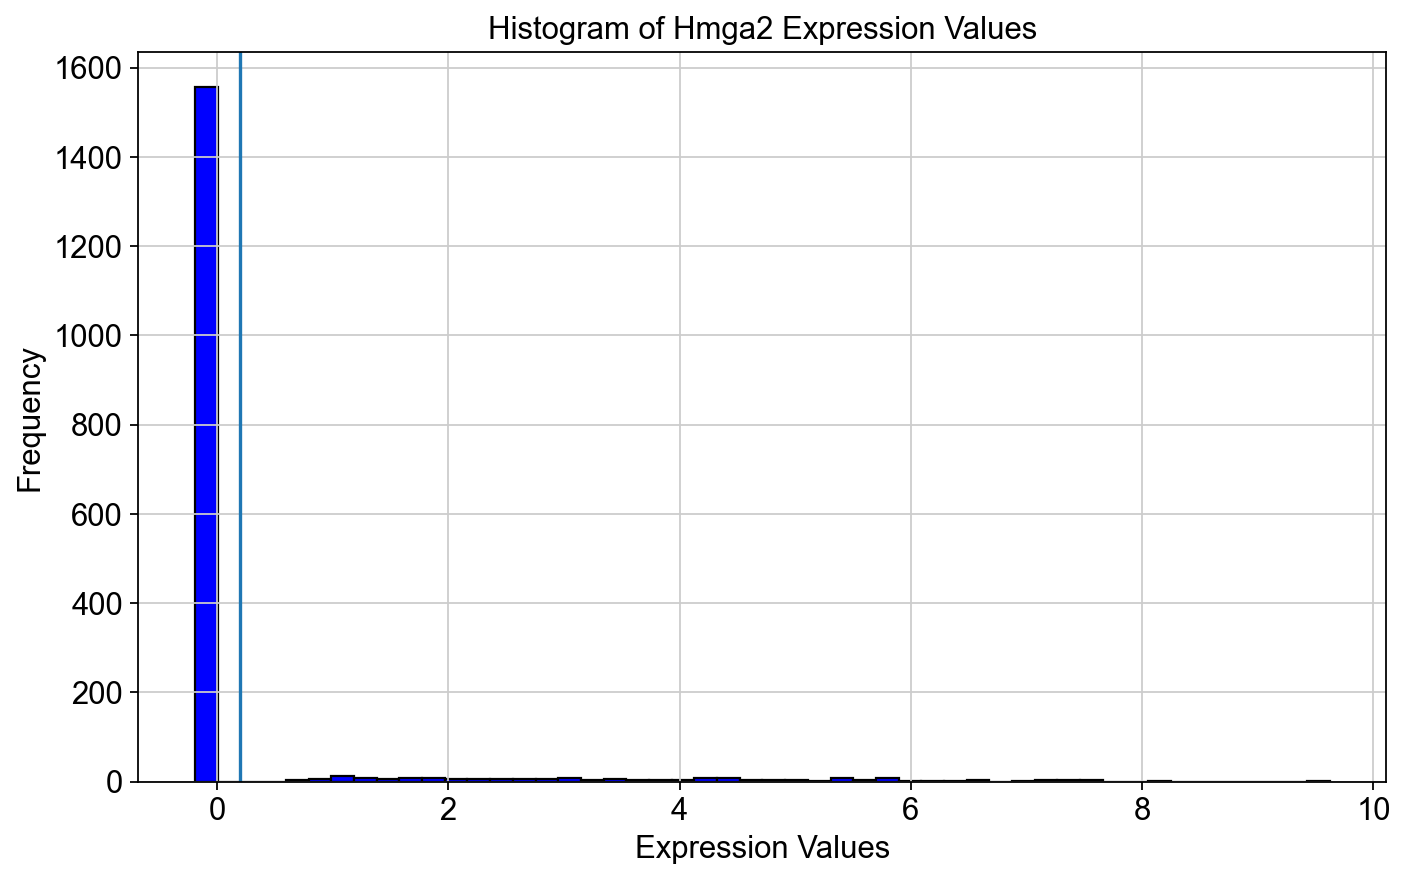

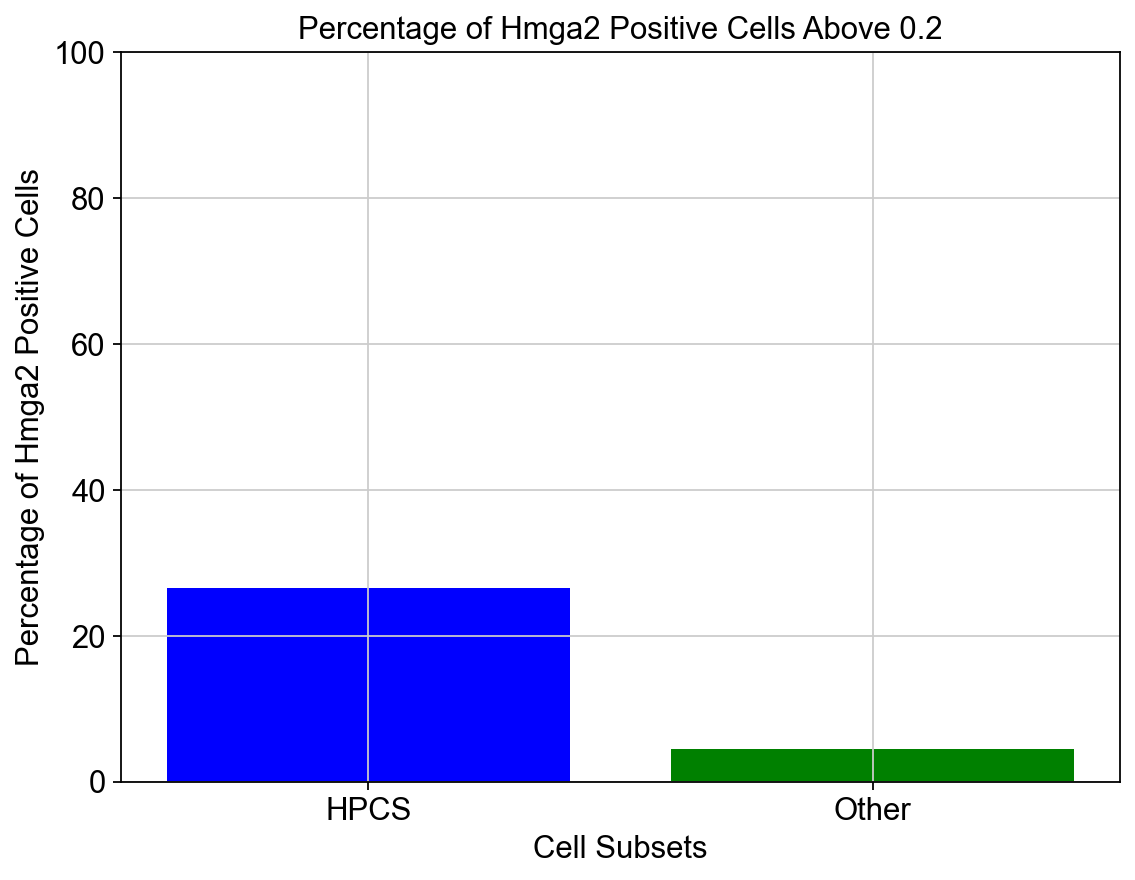

SignificanceResult(statistic=7.804861488321564, pvalue=2.519220266249418e-23)

In [48]:
gene = 'Hmga2'
expression_values = adata[:, gene].X
threshold = 0.2

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata2[adata2.obs['HPCS_cell'] == 1,:]
subset_b = adata2[adata2.obs['HPCS_cell'] == 0,:]

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Fig2i_{gene}_positive_cells_percentage_14wk.svg')
plt.show()

# Calculate statistics

from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

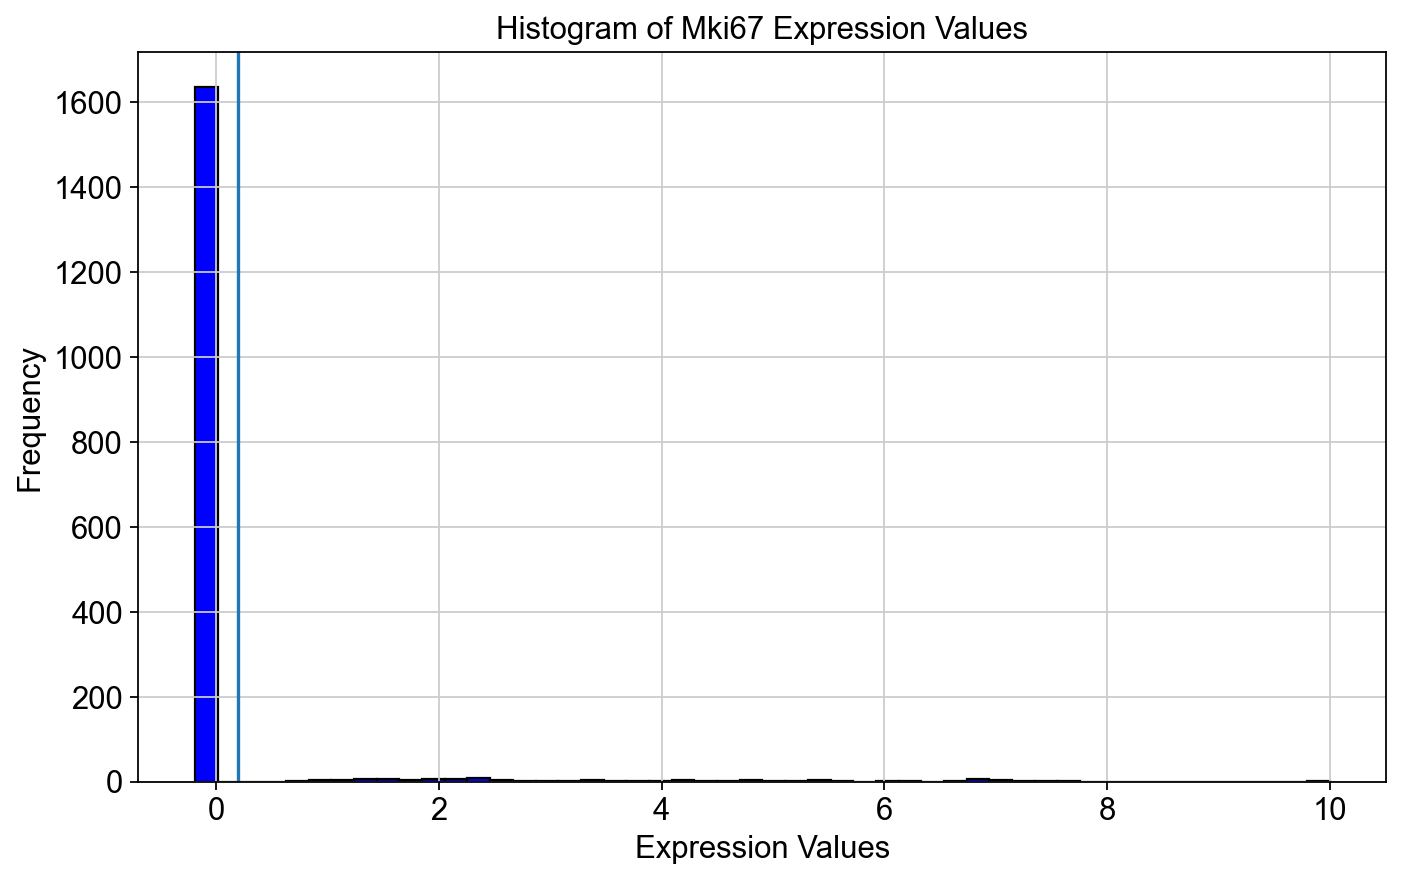

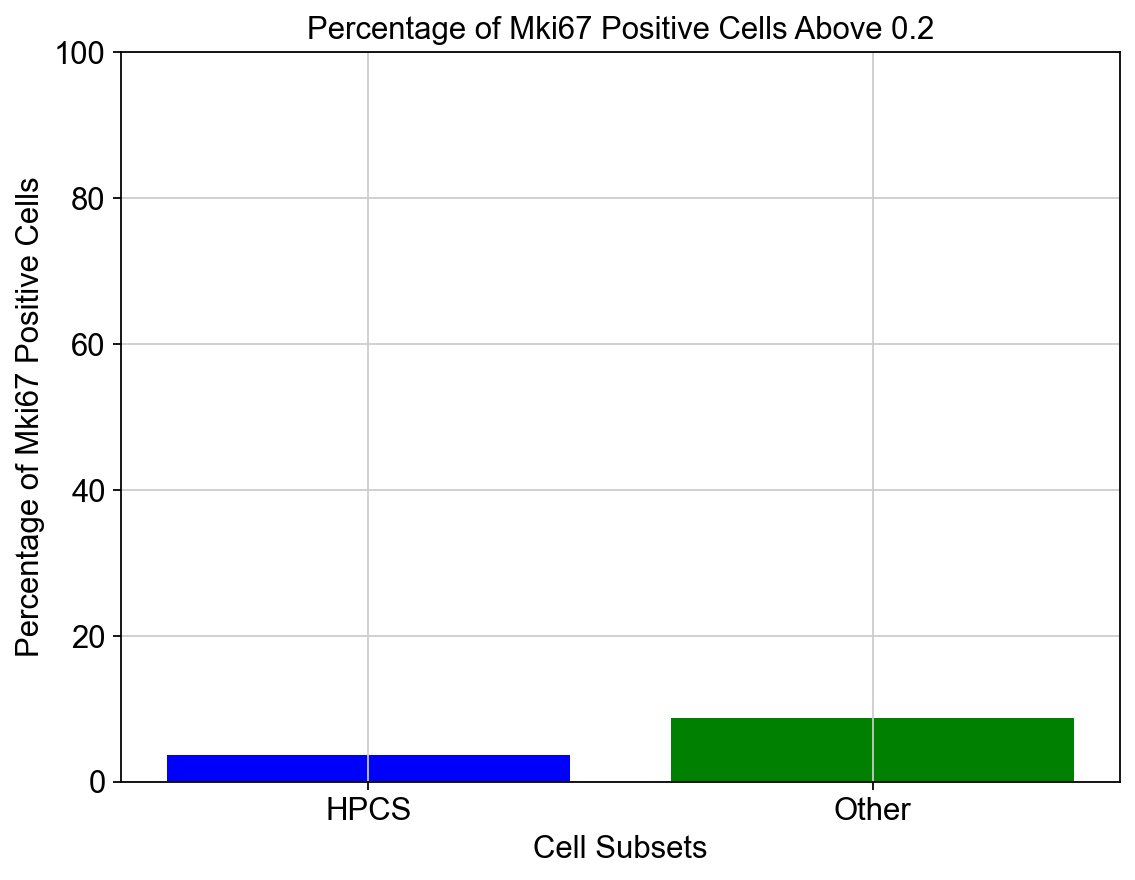

SignificanceResult(statistic=0.3959947299077734, pvalue=0.0024047815340477287)

In [49]:
gene = 'Mki67'
expression_values = adata[:, gene].X
threshold = 0.2

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata2[adata2.obs['HPCS_cell'] == 1,:]
subset_b = adata2[adata2.obs['HPCS_cell'] == 0,:]

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Fig2i_{gene}_positive_cells_percentage_14wk.svg')
plt.show()

#Calculate statistics

from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

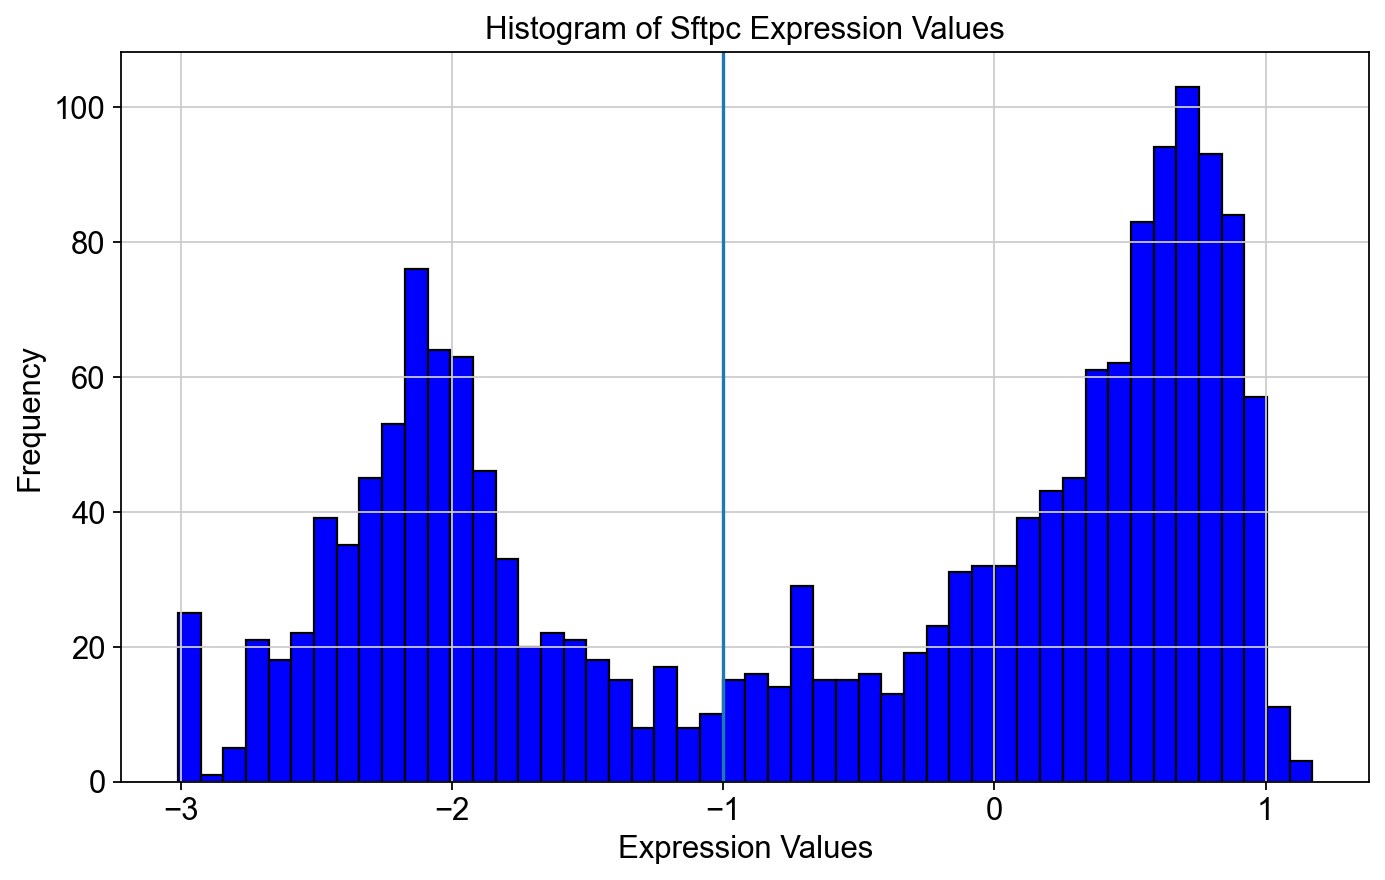

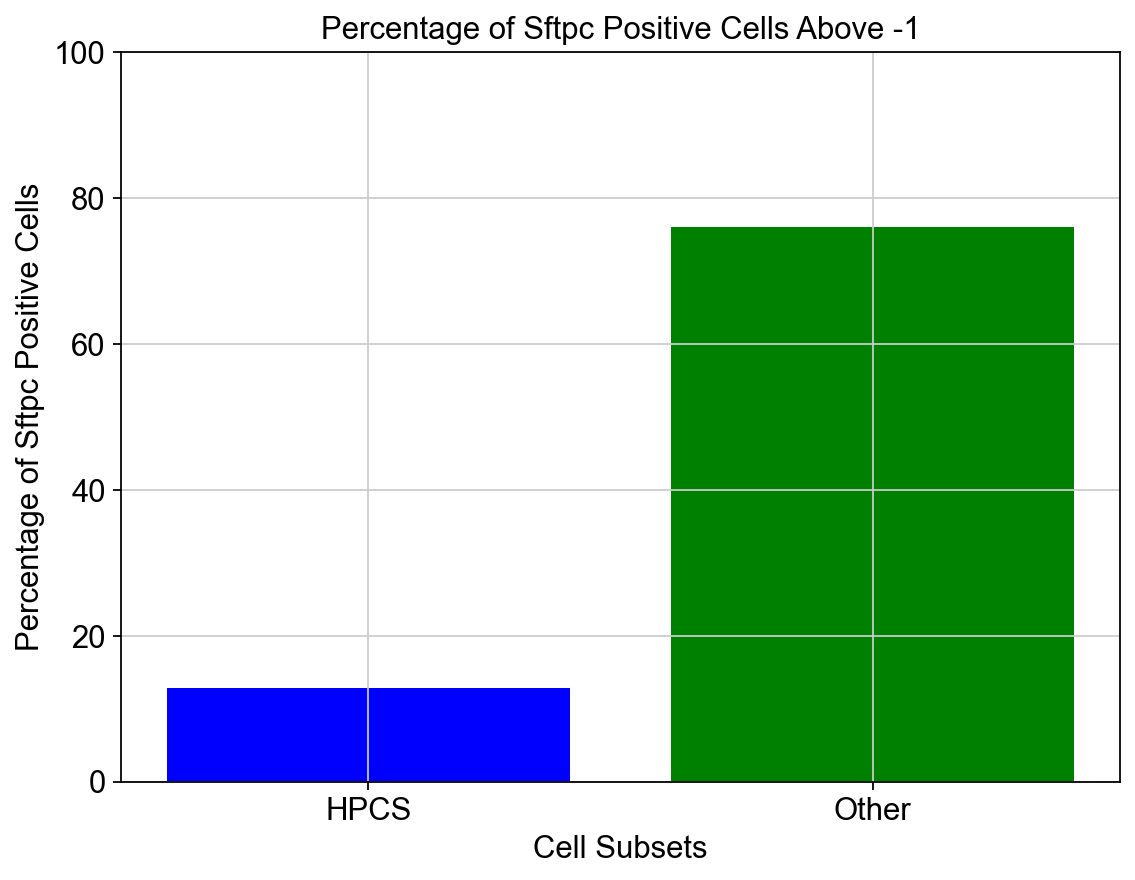

SignificanceResult(statistic=0.046590969667892744, pvalue=5.690474546469731e-88)

In [50]:
gene = 'Sftpc'
expression_values = adata[:, gene].X
threshold = -1

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata2[adata2.obs['HPCS_cell'] == 1,:]
subset_b = adata2[adata2.obs['HPCS_cell'] == 0,:]

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Fig2i_{gene}_positive_cells_percentage_14wk.svg')
plt.show()

# Calculate statistics
from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

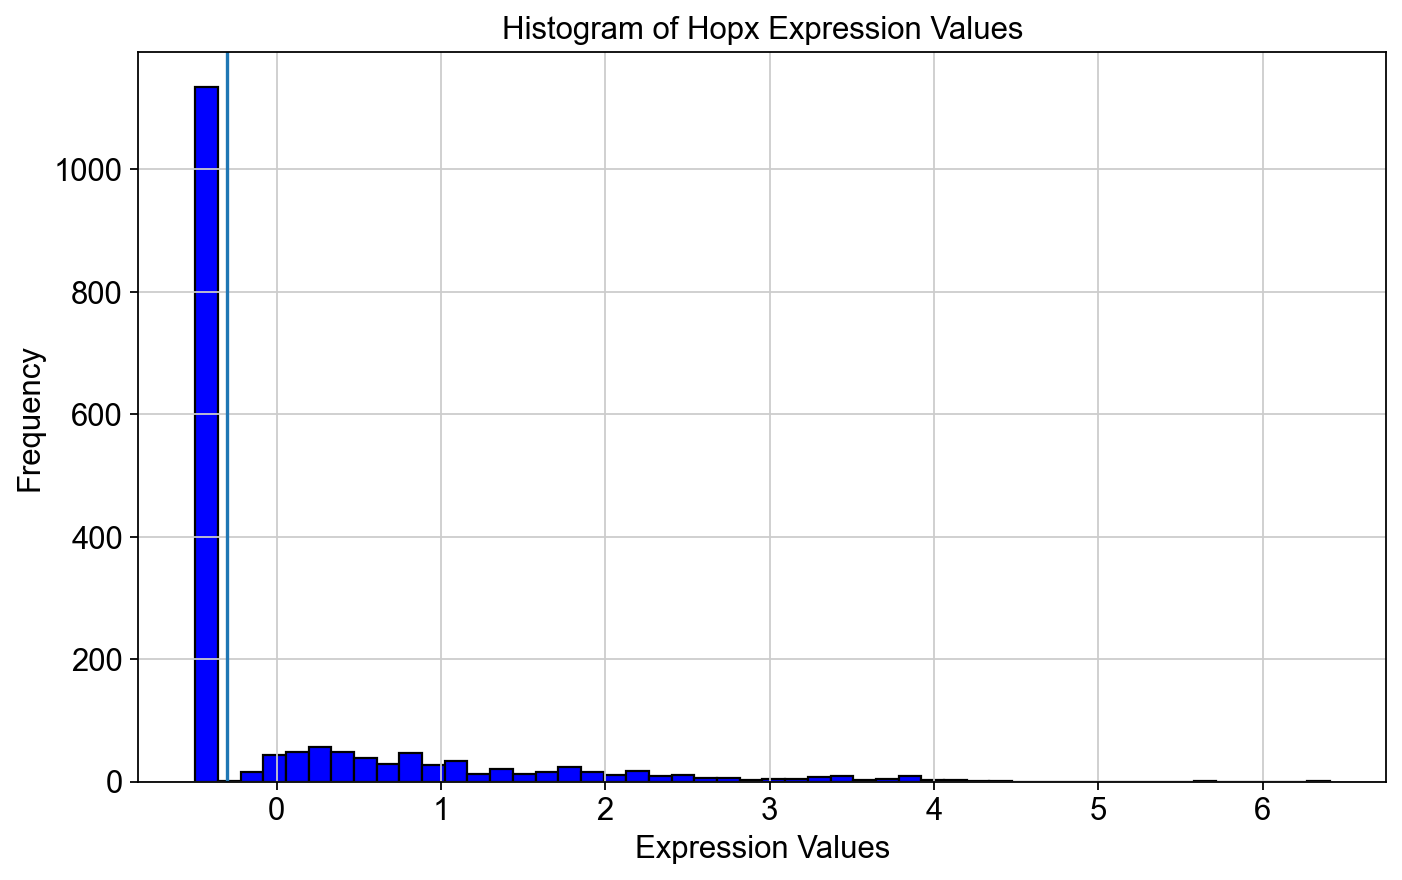

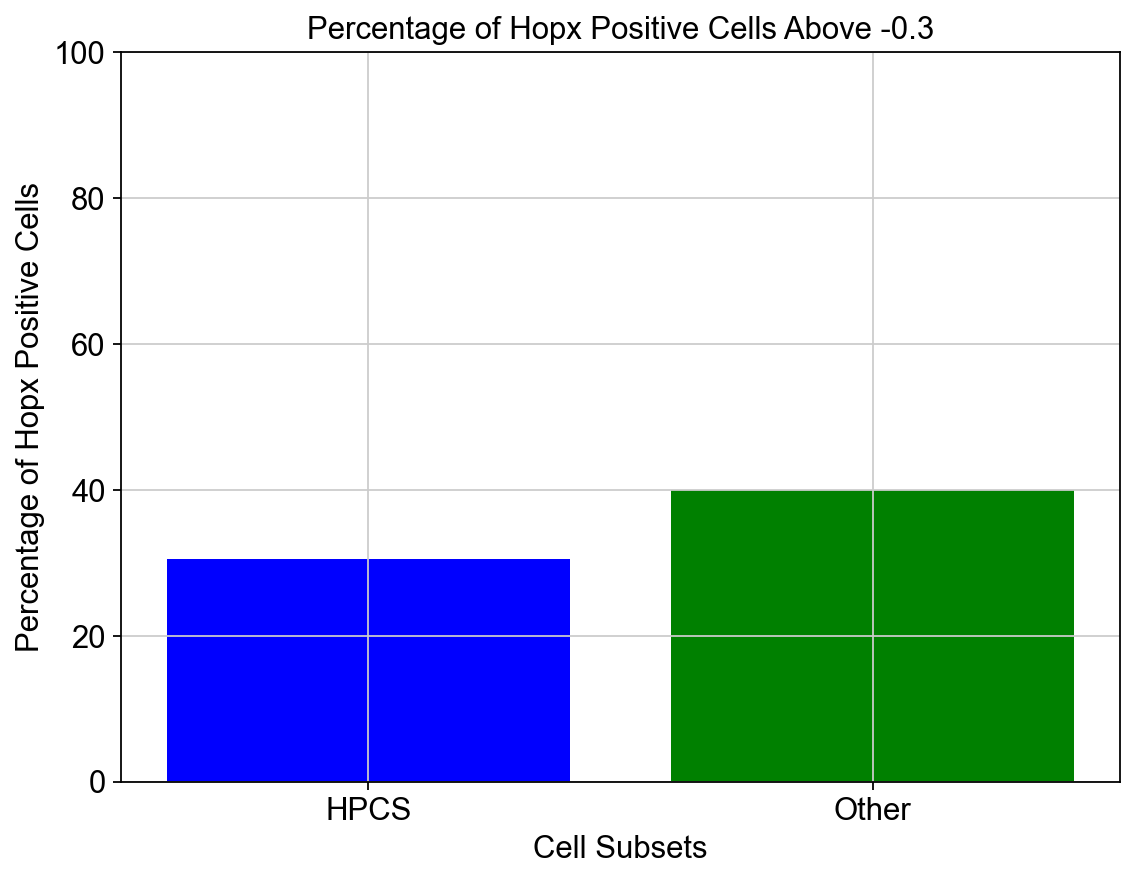

SignificanceResult(statistic=0.657491626585393, pvalue=0.0031235550184844736)

In [51]:
gene = 'Hopx'
expression_values = adata[:, gene].X
threshold = -0.3

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata2[adata2.obs['HPCS_cell'] == 1,:]
subset_b = adata2[adata2.obs['HPCS_cell'] == 0,:]

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Fig2i_{gene}_positive_cells_percentage_14wk.svg')
plt.show()

#Calculate statistics
from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

#### 8 week timepoints

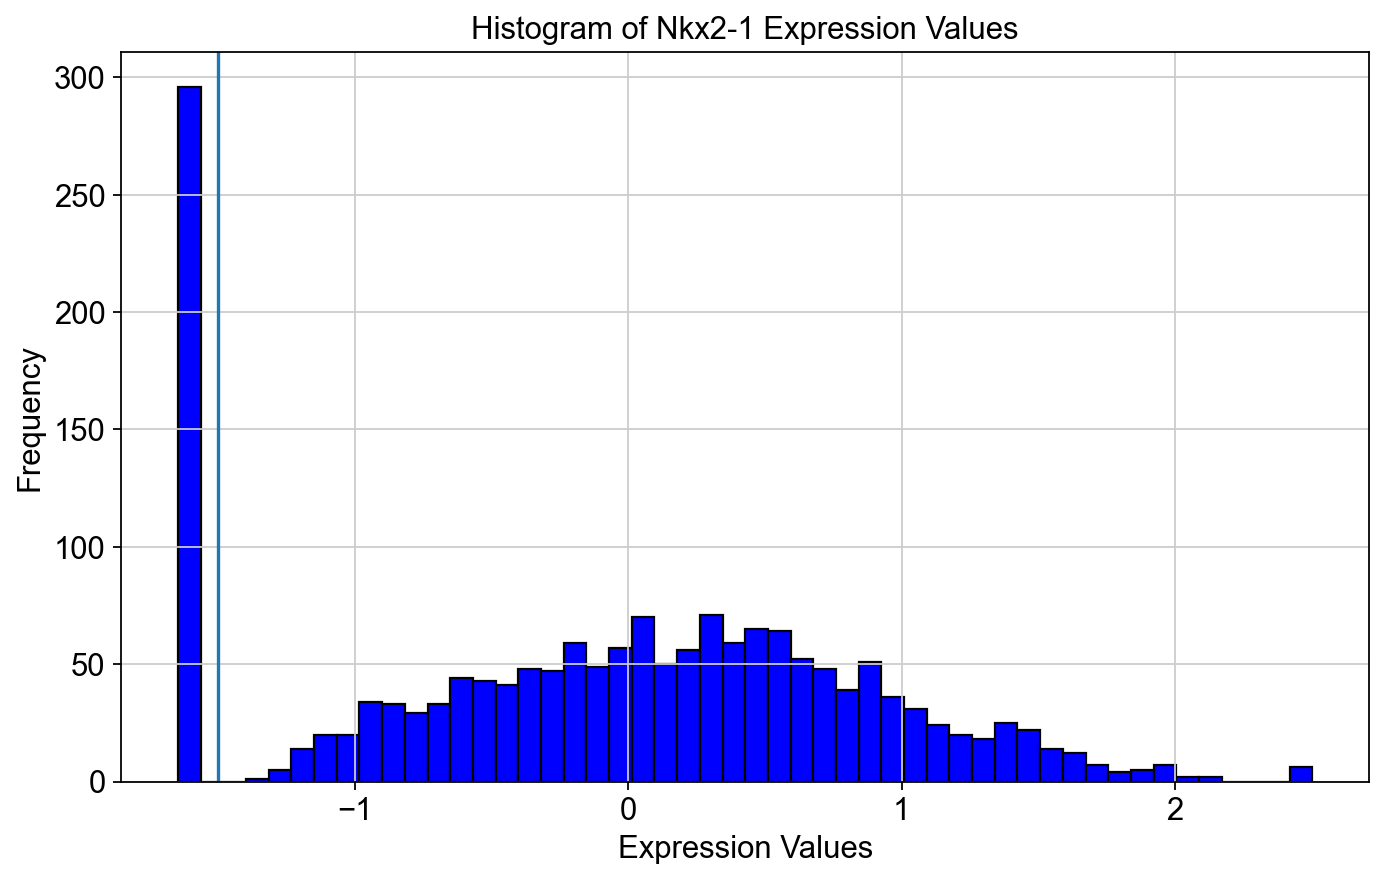

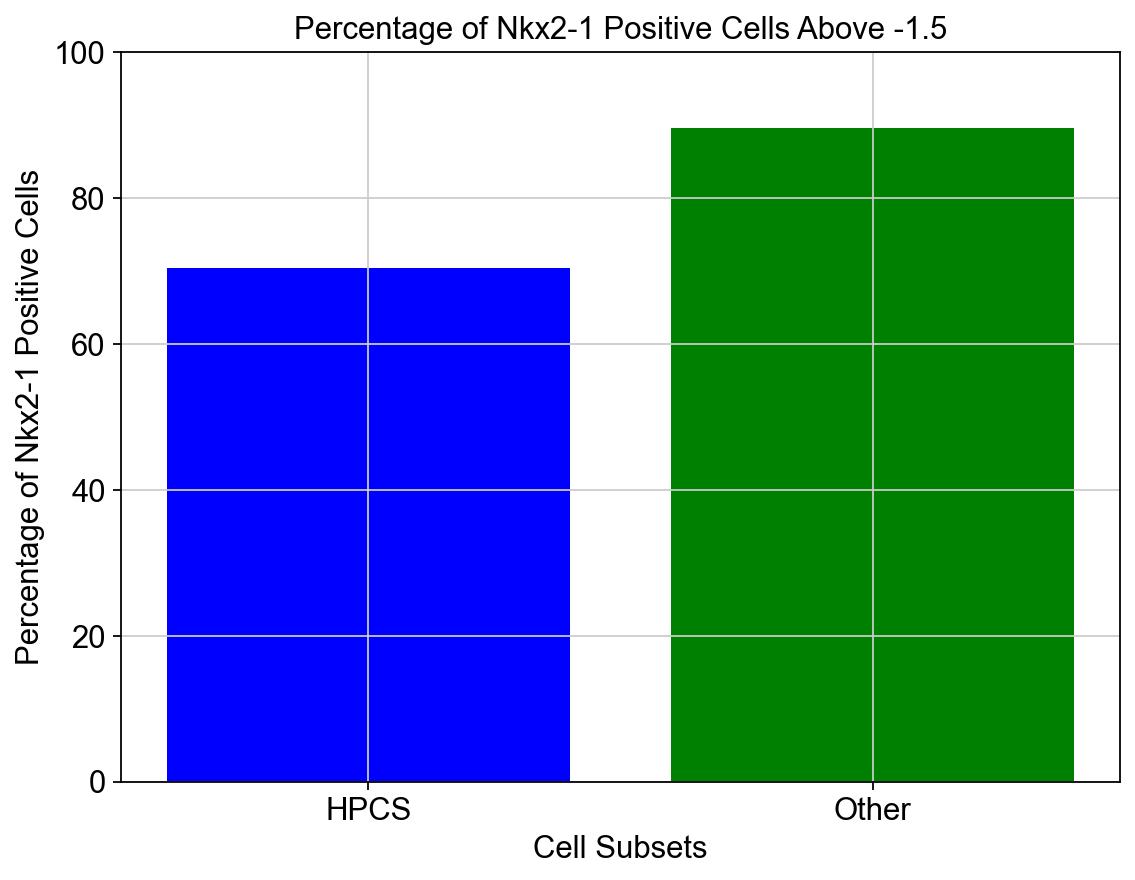

SignificanceResult(statistic=0.2783625730994152, pvalue=1.0644647856065833e-08)

In [52]:
gene = 'Nkx2-1'
expression_values = adata[:, gene].X
threshold = -1.5

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata3[adata3.obs['HPCS_cell'] == 1,:] #6 week
subset_b = adata3[adata3.obs['HPCS_cell'] == 0,:] #12 week

# Extract the expression values for the gene 'Mki67' for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Ext_Data_Fig5f_{gene}_positive_cells_percentage_8wk.svg')
plt.show()

#Calculate statistics

from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

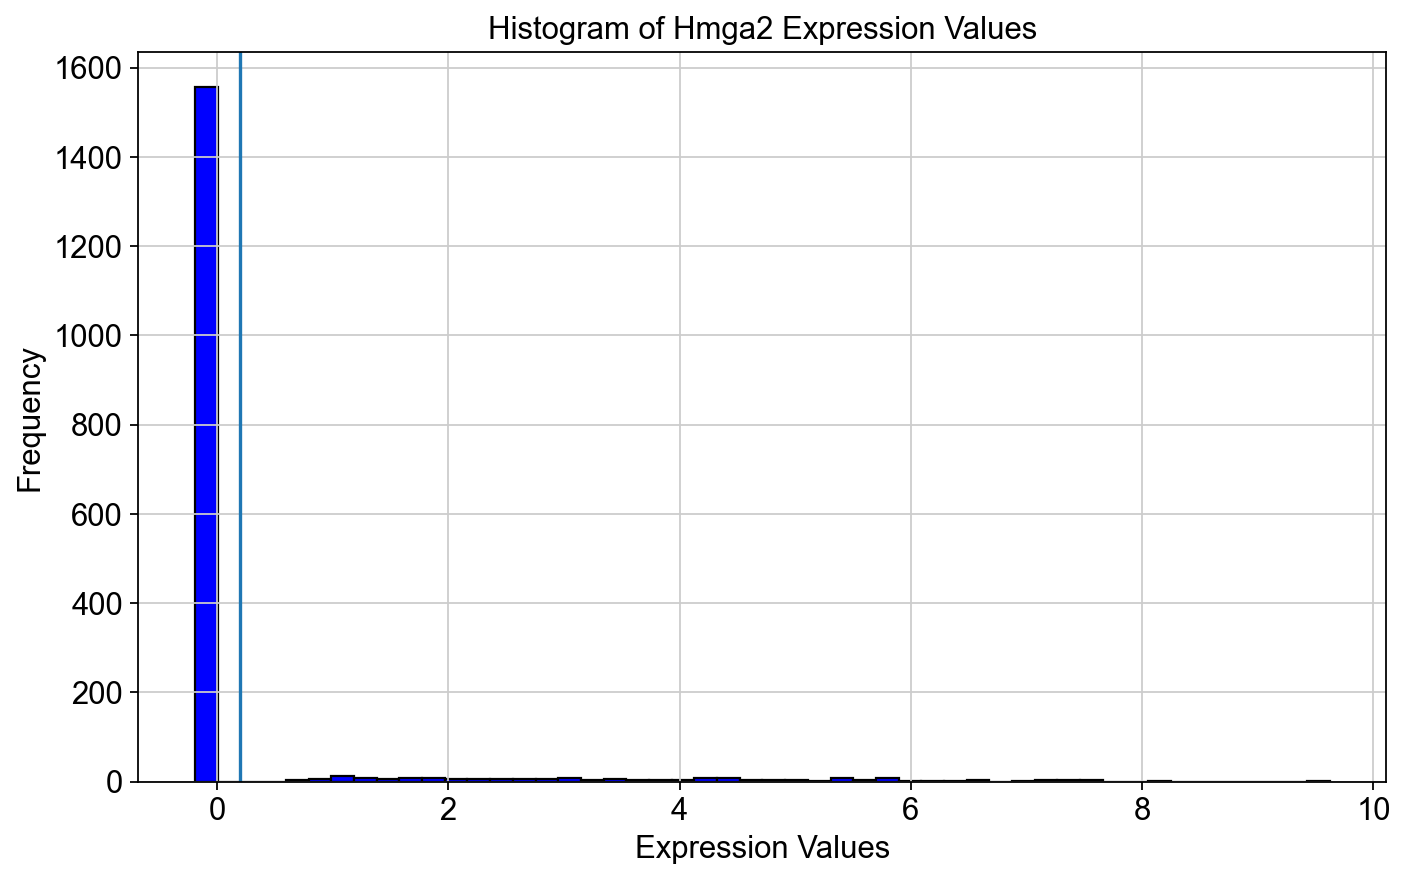

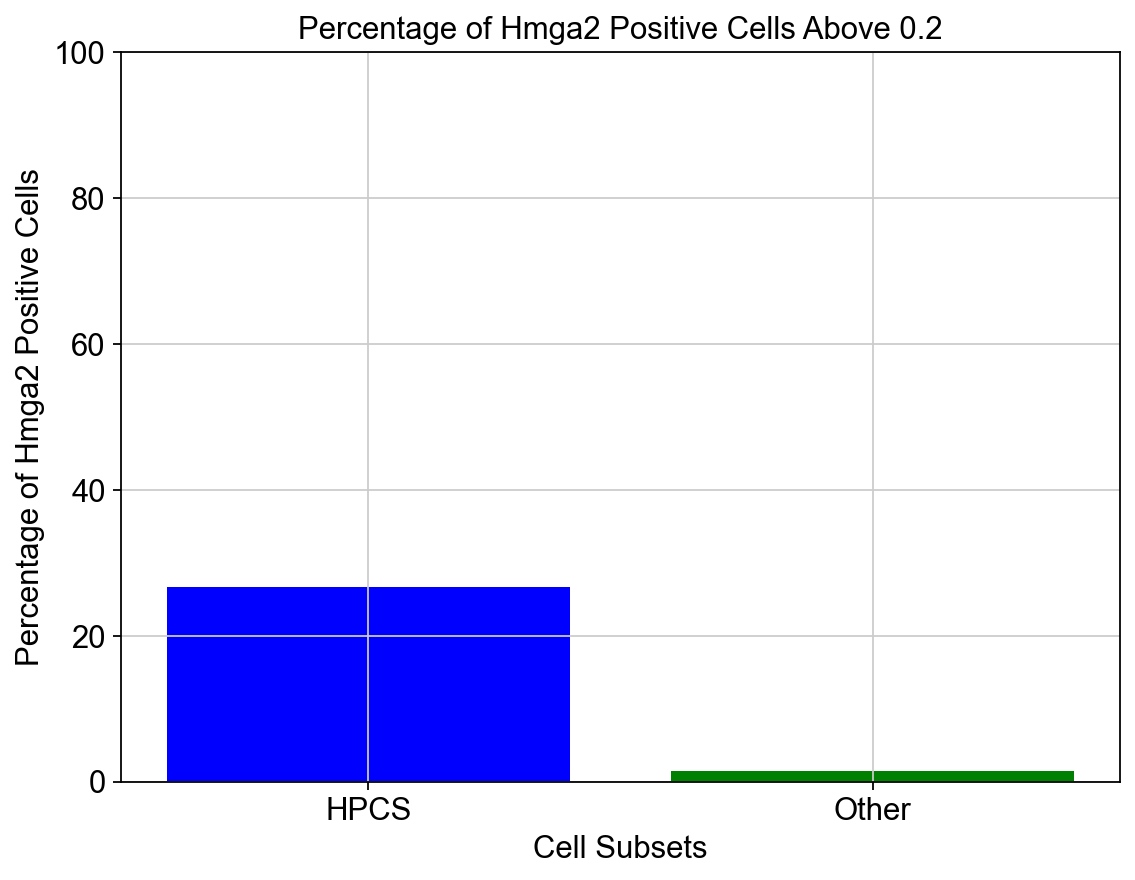

SignificanceResult(statistic=25.630040322580644, pvalue=1.4309168411377116e-23)

In [53]:
gene = 'Hmga2'
expression_values = adata[:, gene].X
threshold = .2

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata3[adata3.obs['HPCS_cell'] == 1,:]
subset_b = adata3[adata3.obs['HPCS_cell'] == 0,:]

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Ext_Data_Fig5f_{gene}_positive_cells_percentage_8wk.svg')
plt.show()

#Calculate statistics

from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

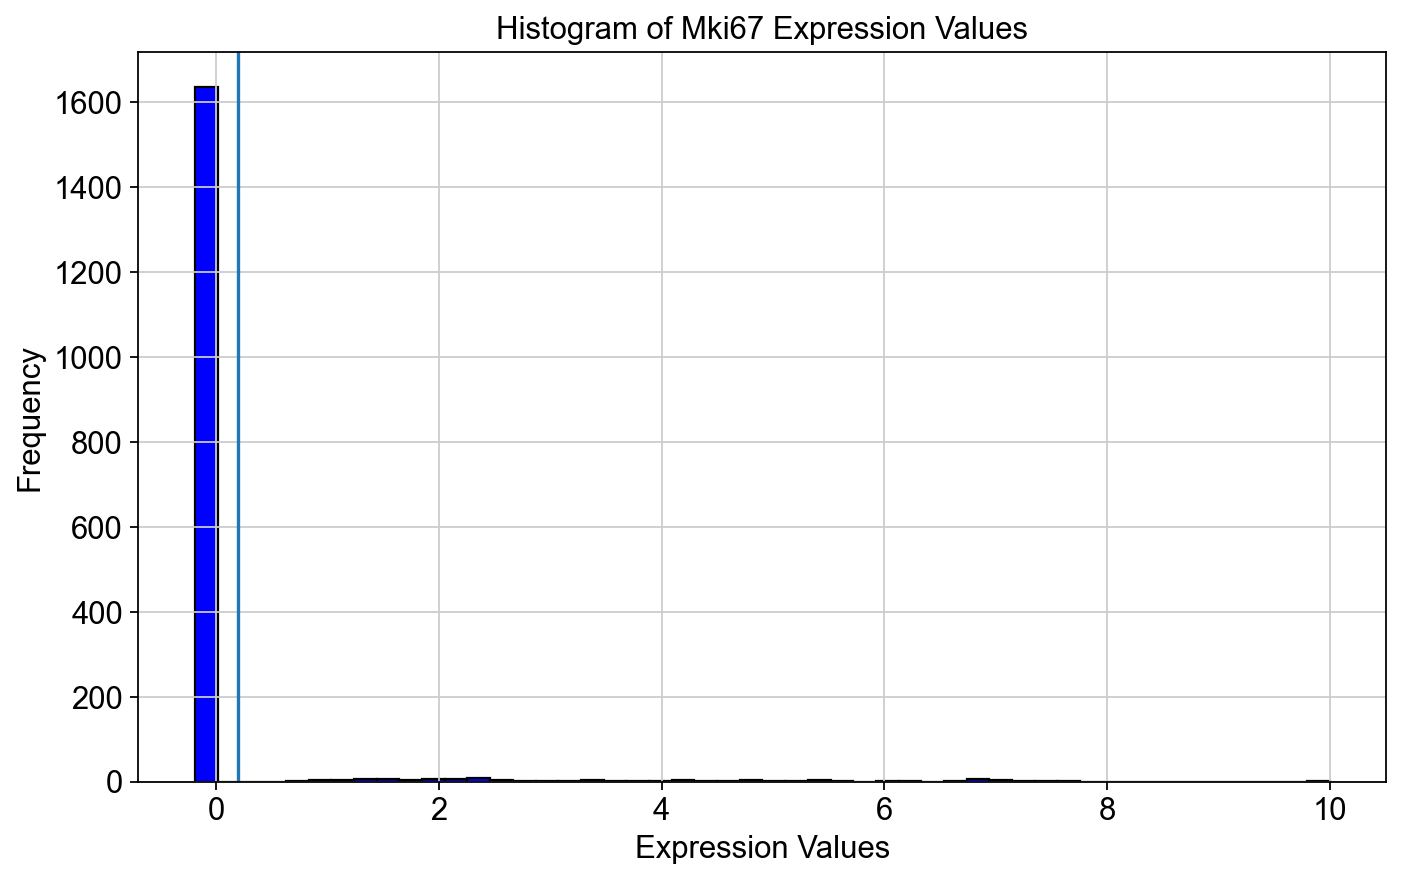

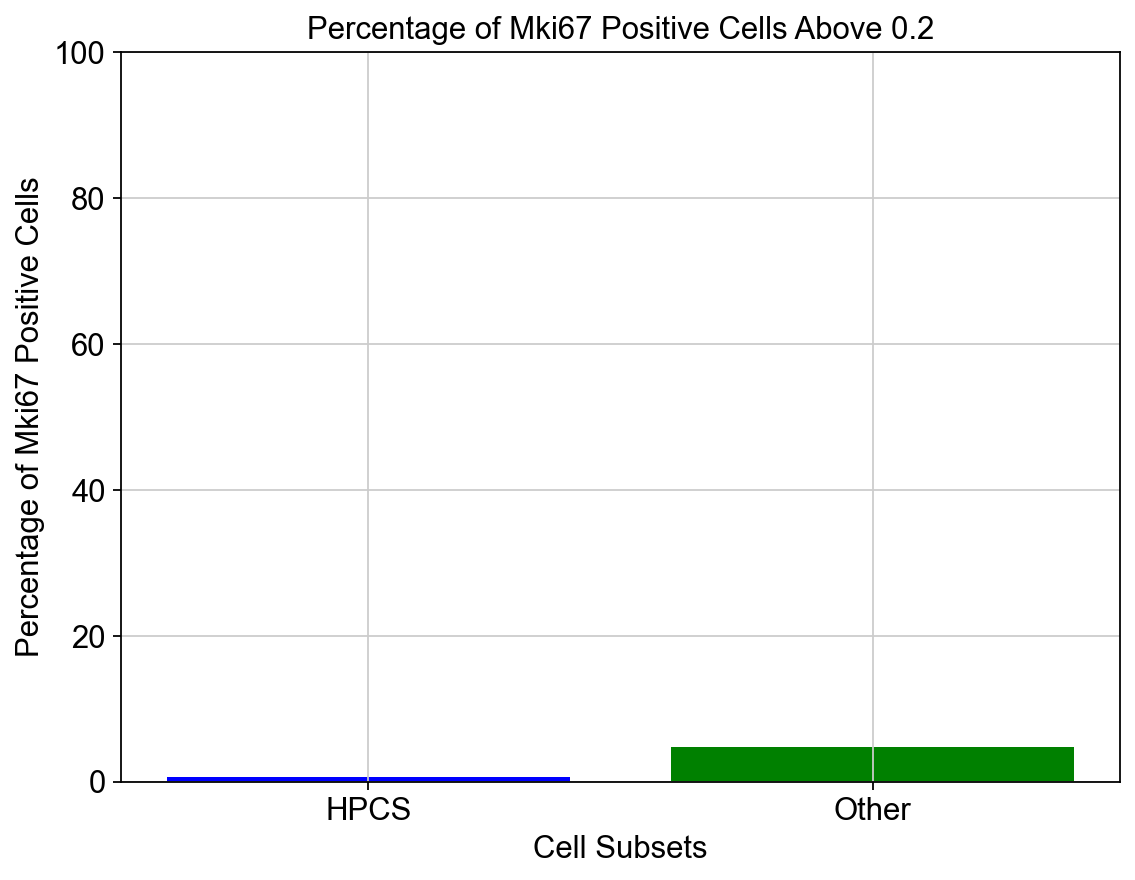

SignificanceResult(statistic=0.12037037037037036, pvalue=0.0101311048258532)

In [54]:
gene = 'Mki67'
expression_values = adata[:, gene].X
threshold = 0.2

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata3[adata3.obs['HPCS_cell'] == 1,:]
subset_b = adata3[adata3.obs['HPCS_cell'] == 0,:]

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Ext_Data_Fig5f_{gene}_positive_cells_percentage_8wk.svg')
plt.show()

#Calculate statistics

from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

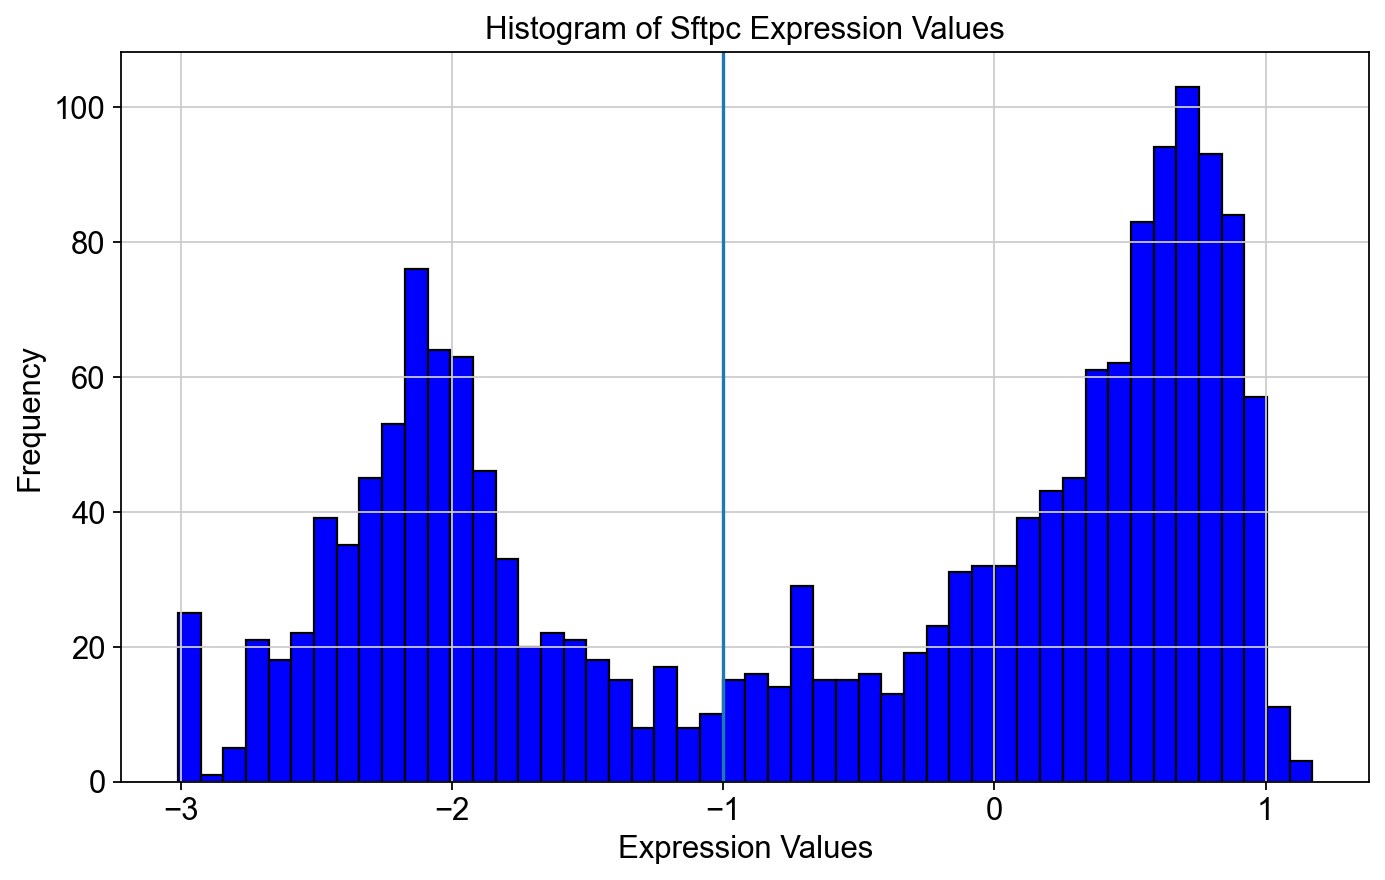

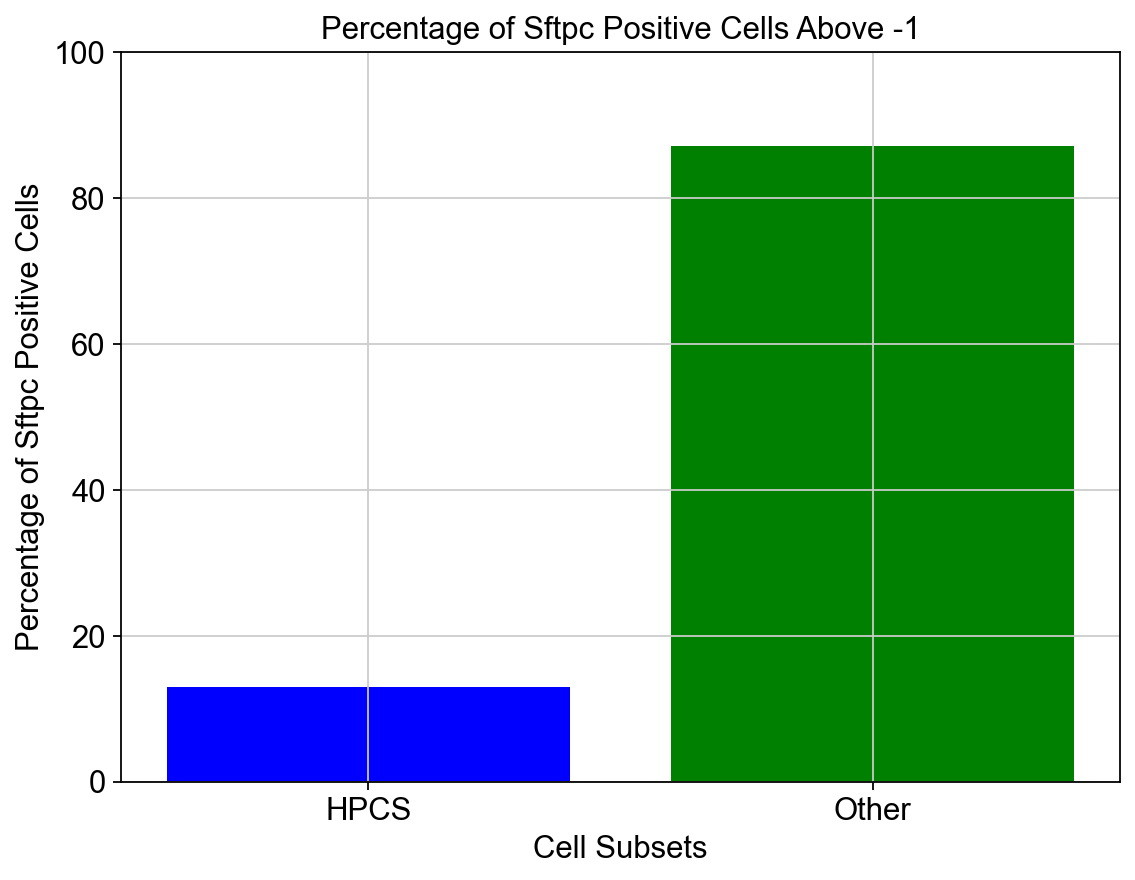

SignificanceResult(statistic=0.02219404795986531, pvalue=1.0791867362516242e-73)

In [55]:
gene = 'Sftpc'
expression_values = adata[:, gene].X
threshold = -1

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata3[adata3.obs['HPCS_cell'] == 1,:] #6 week
subset_b = adata3[adata3.obs['HPCS_cell'] == 0,:] #12 week

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Ext_Data_Fig5f_{gene}_positive_cells_percentage_8wk.svg')
plt.show()

#Calculate statistics

from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

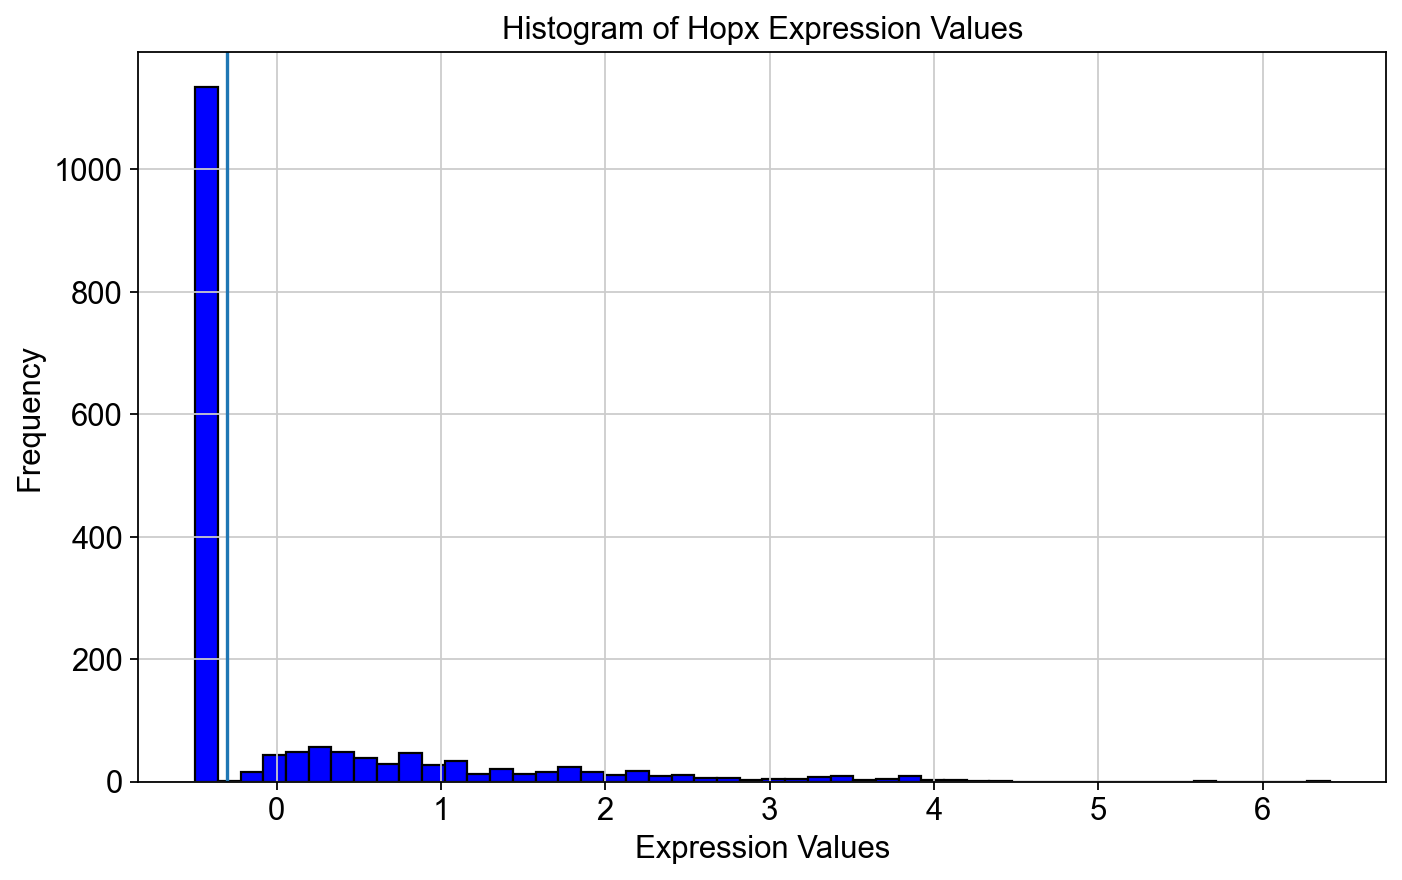

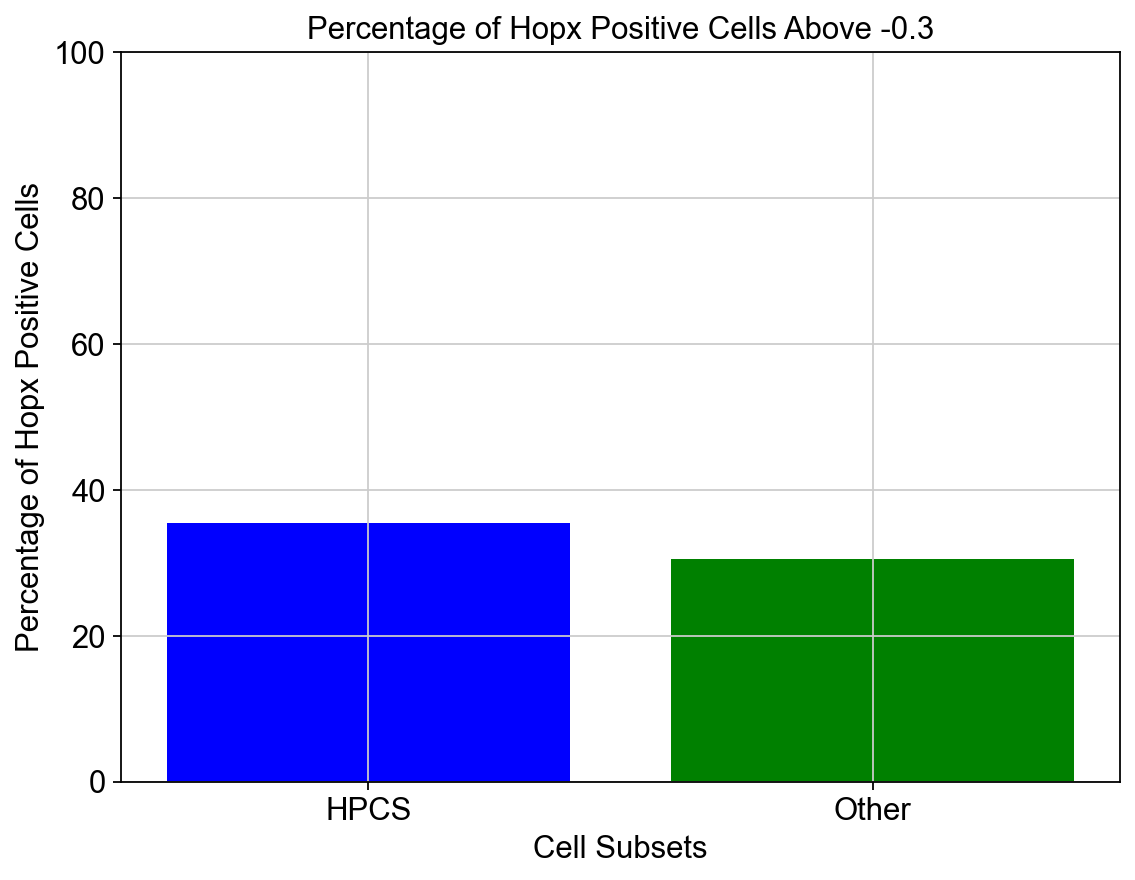

SignificanceResult(statistic=1.251900393184797, pvalue=0.22297732167263212)

In [56]:
gene = 'Hopx'
expression_values = adata[:, gene].X
threshold = -0.3

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(expression_values, bins=50, color='blue', edgecolor='black')
plt.axvline(x=threshold)
plt.xlabel('Expression Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of {gene} Expression Values')
plt.show()

# Bar Graph

subset_a = adata3[adata3.obs['HPCS_cell'] == 1,:]
subset_b = adata3[adata3.obs['HPCS_cell'] == 0,:]

# Extract the expression values for the gene for each subset
expression_values_a = subset_a[:, gene].X
expression_values_b = subset_b[:, gene].X

# Calculate the percentage of cells with expression values above the threshold
percent_a = (expression_values_a > threshold).sum() / len(expression_values_a) * 100
percent_b = (expression_values_b > threshold).sum() / len(expression_values_b) * 100

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['HPCS', 'Other'], [percent_a, percent_b], color=['blue', 'green'])
plt.xlabel('Cell Subsets')
plt.ylabel(f'Percentage of {gene} Positive Cells')
plt.title(f'Percentage of {gene} Positive Cells Above {threshold}')
plt.ylim(0, 100)
plt.savefig(f'figures/Ext_Data_Fig5f_{gene}_positive_cells_percentage_8wk.svg')
plt.show()

#Calculate statistics
from scipy.stats import fisher_exact
table = [[(expression_values_a > threshold).sum(), (expression_values_a <= threshold).sum()],
        [(expression_values_b > threshold).sum(), (expression_values_b <= threshold).sum()]]
fisher_exact(table)

### Generate uMAPs

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


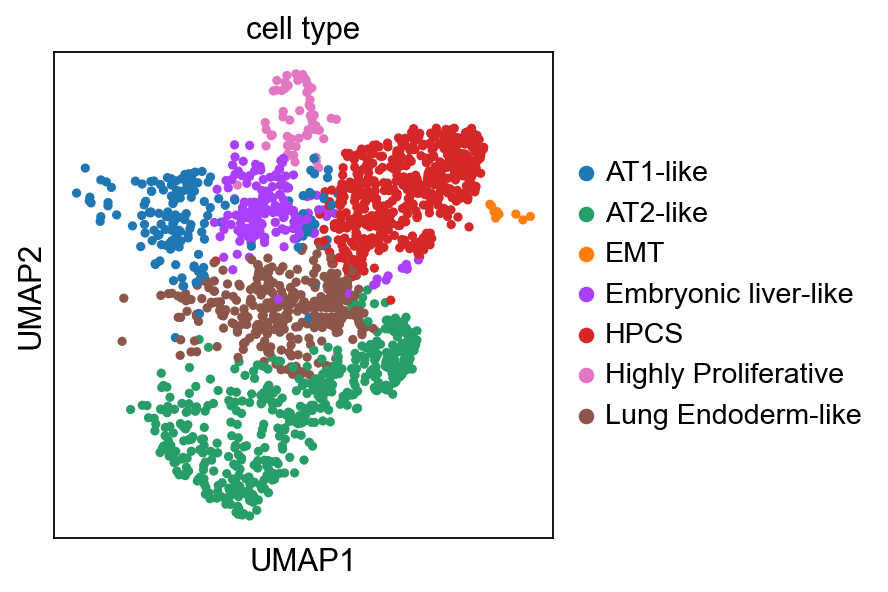

In [57]:
sc.pl.umap(adata,color=['cell type'], save='Ext_Data_Fig5a_cell state umap.svg')
#sc.pl.umap(adata,color=['Slc4a11'], save='Slc4a11 umap.svg', cmap='Reds')
#sc.pl.umap(adata,color=['iDTR'], save='DTR umap.svg', cmap='Reds')
#sc.pl.umap(adata,color=['Cluster 5'], save='Cluster 5 umap.svg', cmap='Reds')

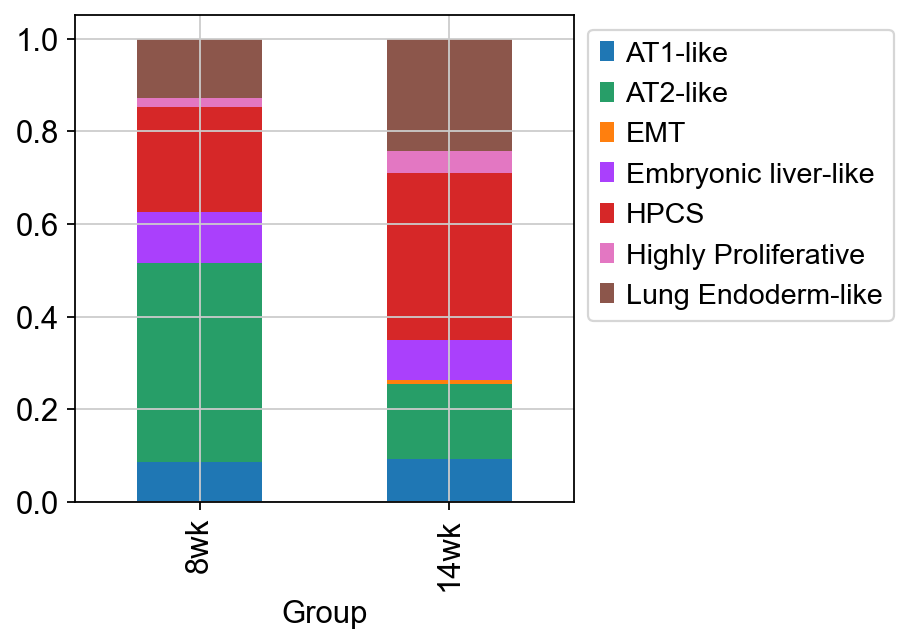

In [58]:
ordered = ['8wk','14wk']
cell_proportion_df = pd.crosstab(adata.obs['cell type'],adata.obs['Group'], normalize='columns')[ordered].T.plot(kind='bar', stacked=True, color=adata.uns["cell type_colors"]).legend(bbox_to_anchor=(1,1))
cell_proportion_df.get_figure().savefig('figures/Fig2d_cell state proportions.svg')

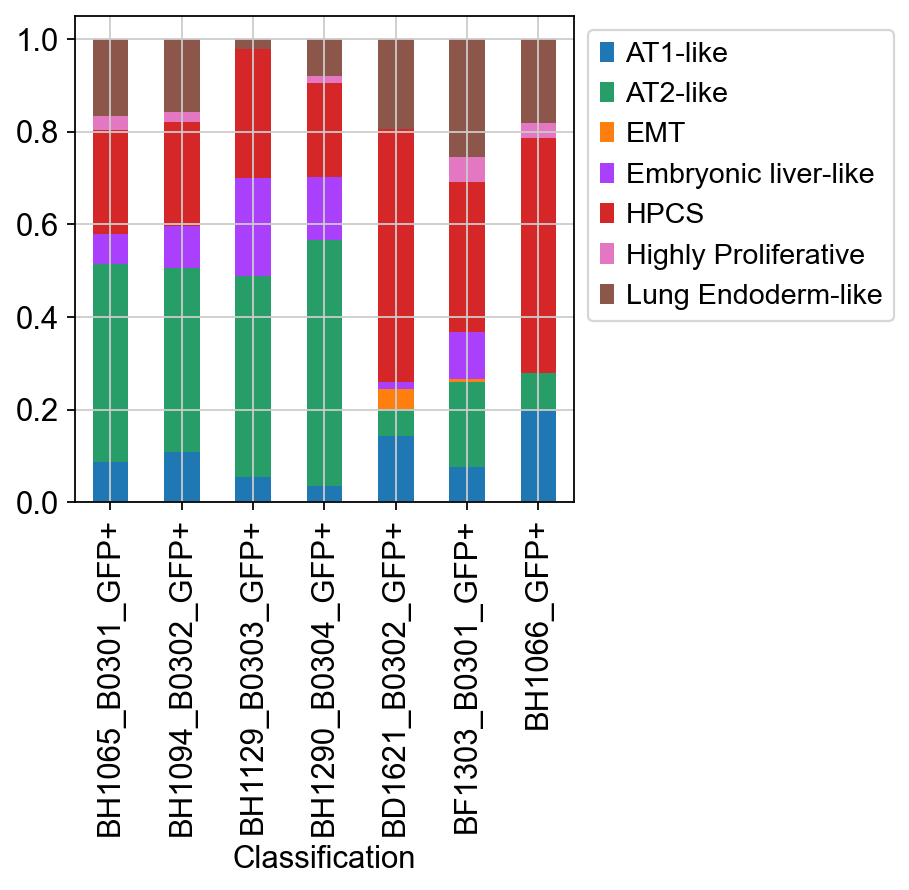

In [59]:
ordered = ['BH1065_B0301_GFP+','BH1094_B0302_GFP+','BH1129_B0303_GFP+','BH1290_B0304_GFP+','BD1621_B0302_GFP+','BF1303_B0301_GFP+','BH1066_GFP+']
cell_proportion_df = pd.crosstab(adata.obs['cell type'],adata.obs['Classification'], normalize='columns')[ordered].T.plot(kind='bar', stacked=True,color=adata.uns["cell type_colors"]).legend(bbox_to_anchor=(1,1))
cell_proportion_df.get_figure().savefig('figures/Ext_Data_Fig5b_cellmapbyID2.svg')

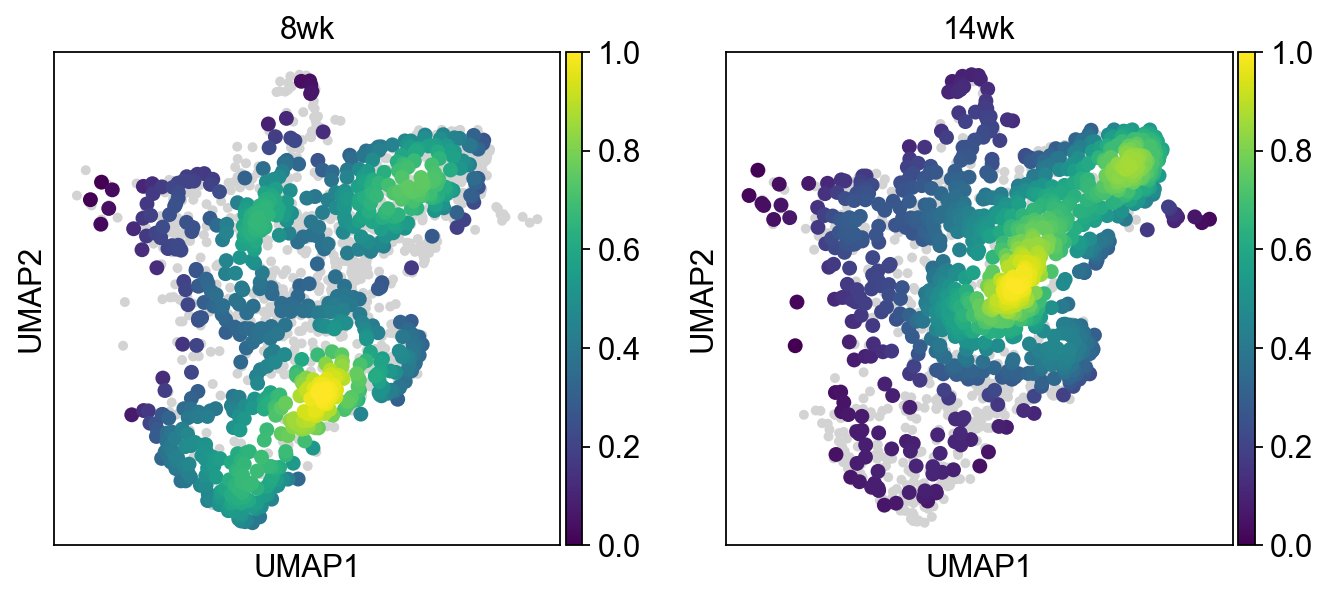

In [60]:
sc.pl.embedding_density(adata, basis='umap', key='umap_density_Group',save='Fig2_f_g_Week.svg',color_map='viridis',)

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


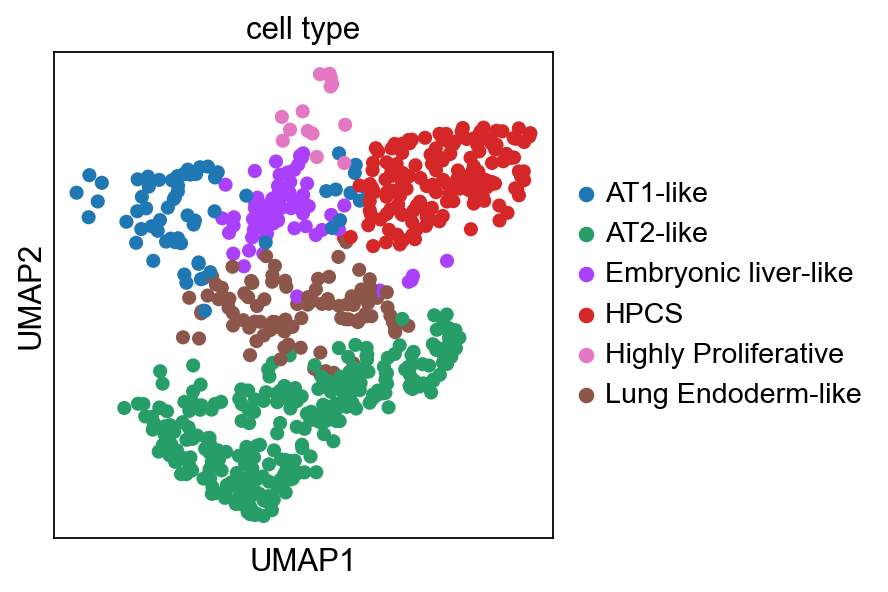

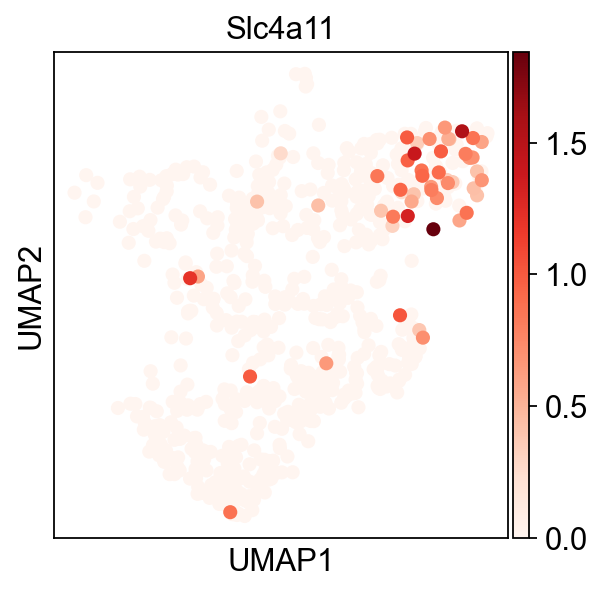

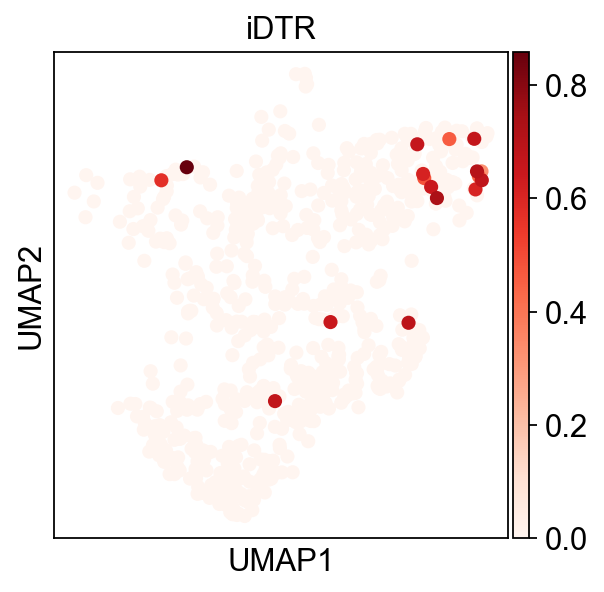

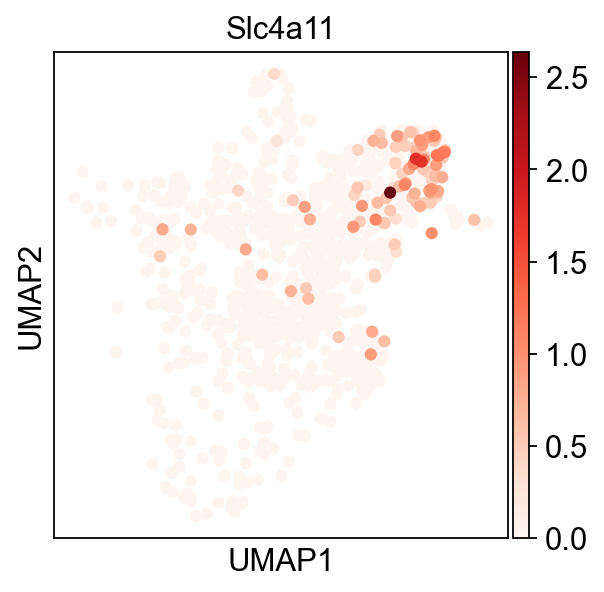

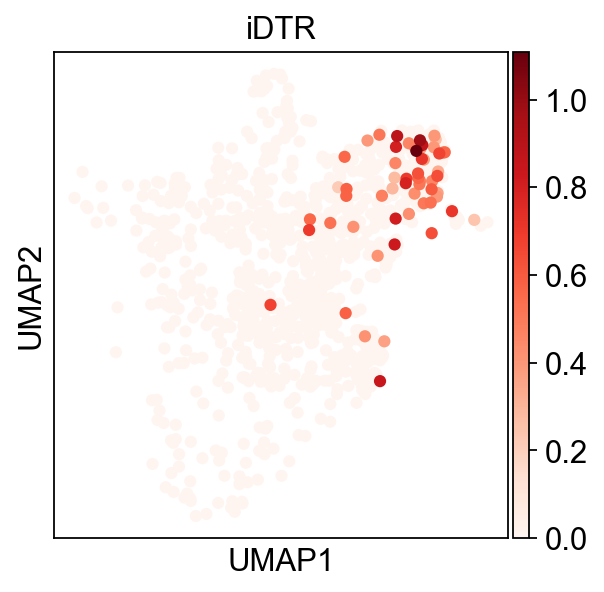

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


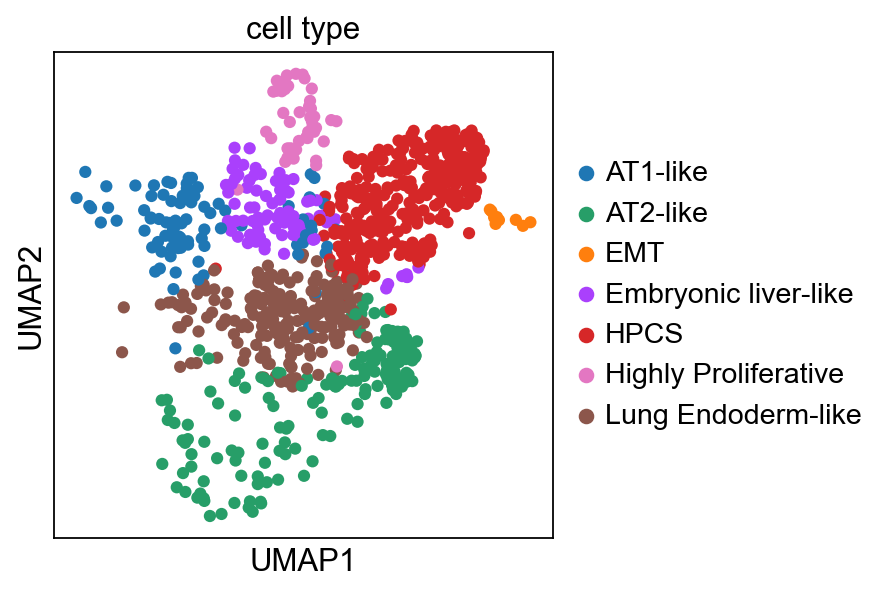

In [61]:
sc.pl.umap(adata[adata.obs.Group=='8wk',:],color=['cell type'], save='Fig2f_cell state umap-8wk.svg')
sc.pl.umap(adata[adata.obs.Group=='8wk',:],color=['Slc4a11'], save='Ext_Data_Fig5c_Slc4a11 umap-8wk.svg', cmap='Reds')
sc.pl.umap(adata[adata.obs.Group=='8wk',:],color=['iDTR'], save='Ext_Data_Fig5c_DTR umap-8wk.svg', cmap='Reds')
#sc.pl.umap(adata[adata.obs.Group=='8wk',:],color=['Cluster 5'], save='HPCS umap-8wk.svg', cmap='Reds')
sc.pl.umap(adata[adata.obs.Group=='14wk',:],color=['Slc4a11'], save='Ext_Data_Fig5d_Slc4a11 umap-14wk.svg', cmap='Reds')
sc.pl.umap(adata[adata.obs.Group=='14wk',:],color=['iDTR'], save='Ext_Data_Fig5dDTR umap-14wk.svg', cmap='Reds')
#sc.pl.umap(adata[adata.obs.Group=='14wk',:],color=['Cluster 5'], save='HPCS umap-14wk.svg', cmap='Reds')
sc.pl.umap(adata[adata.obs.Group=='14wk',:],color=['cell type'], save='Fig2g_cell state umap-14wk.svg')

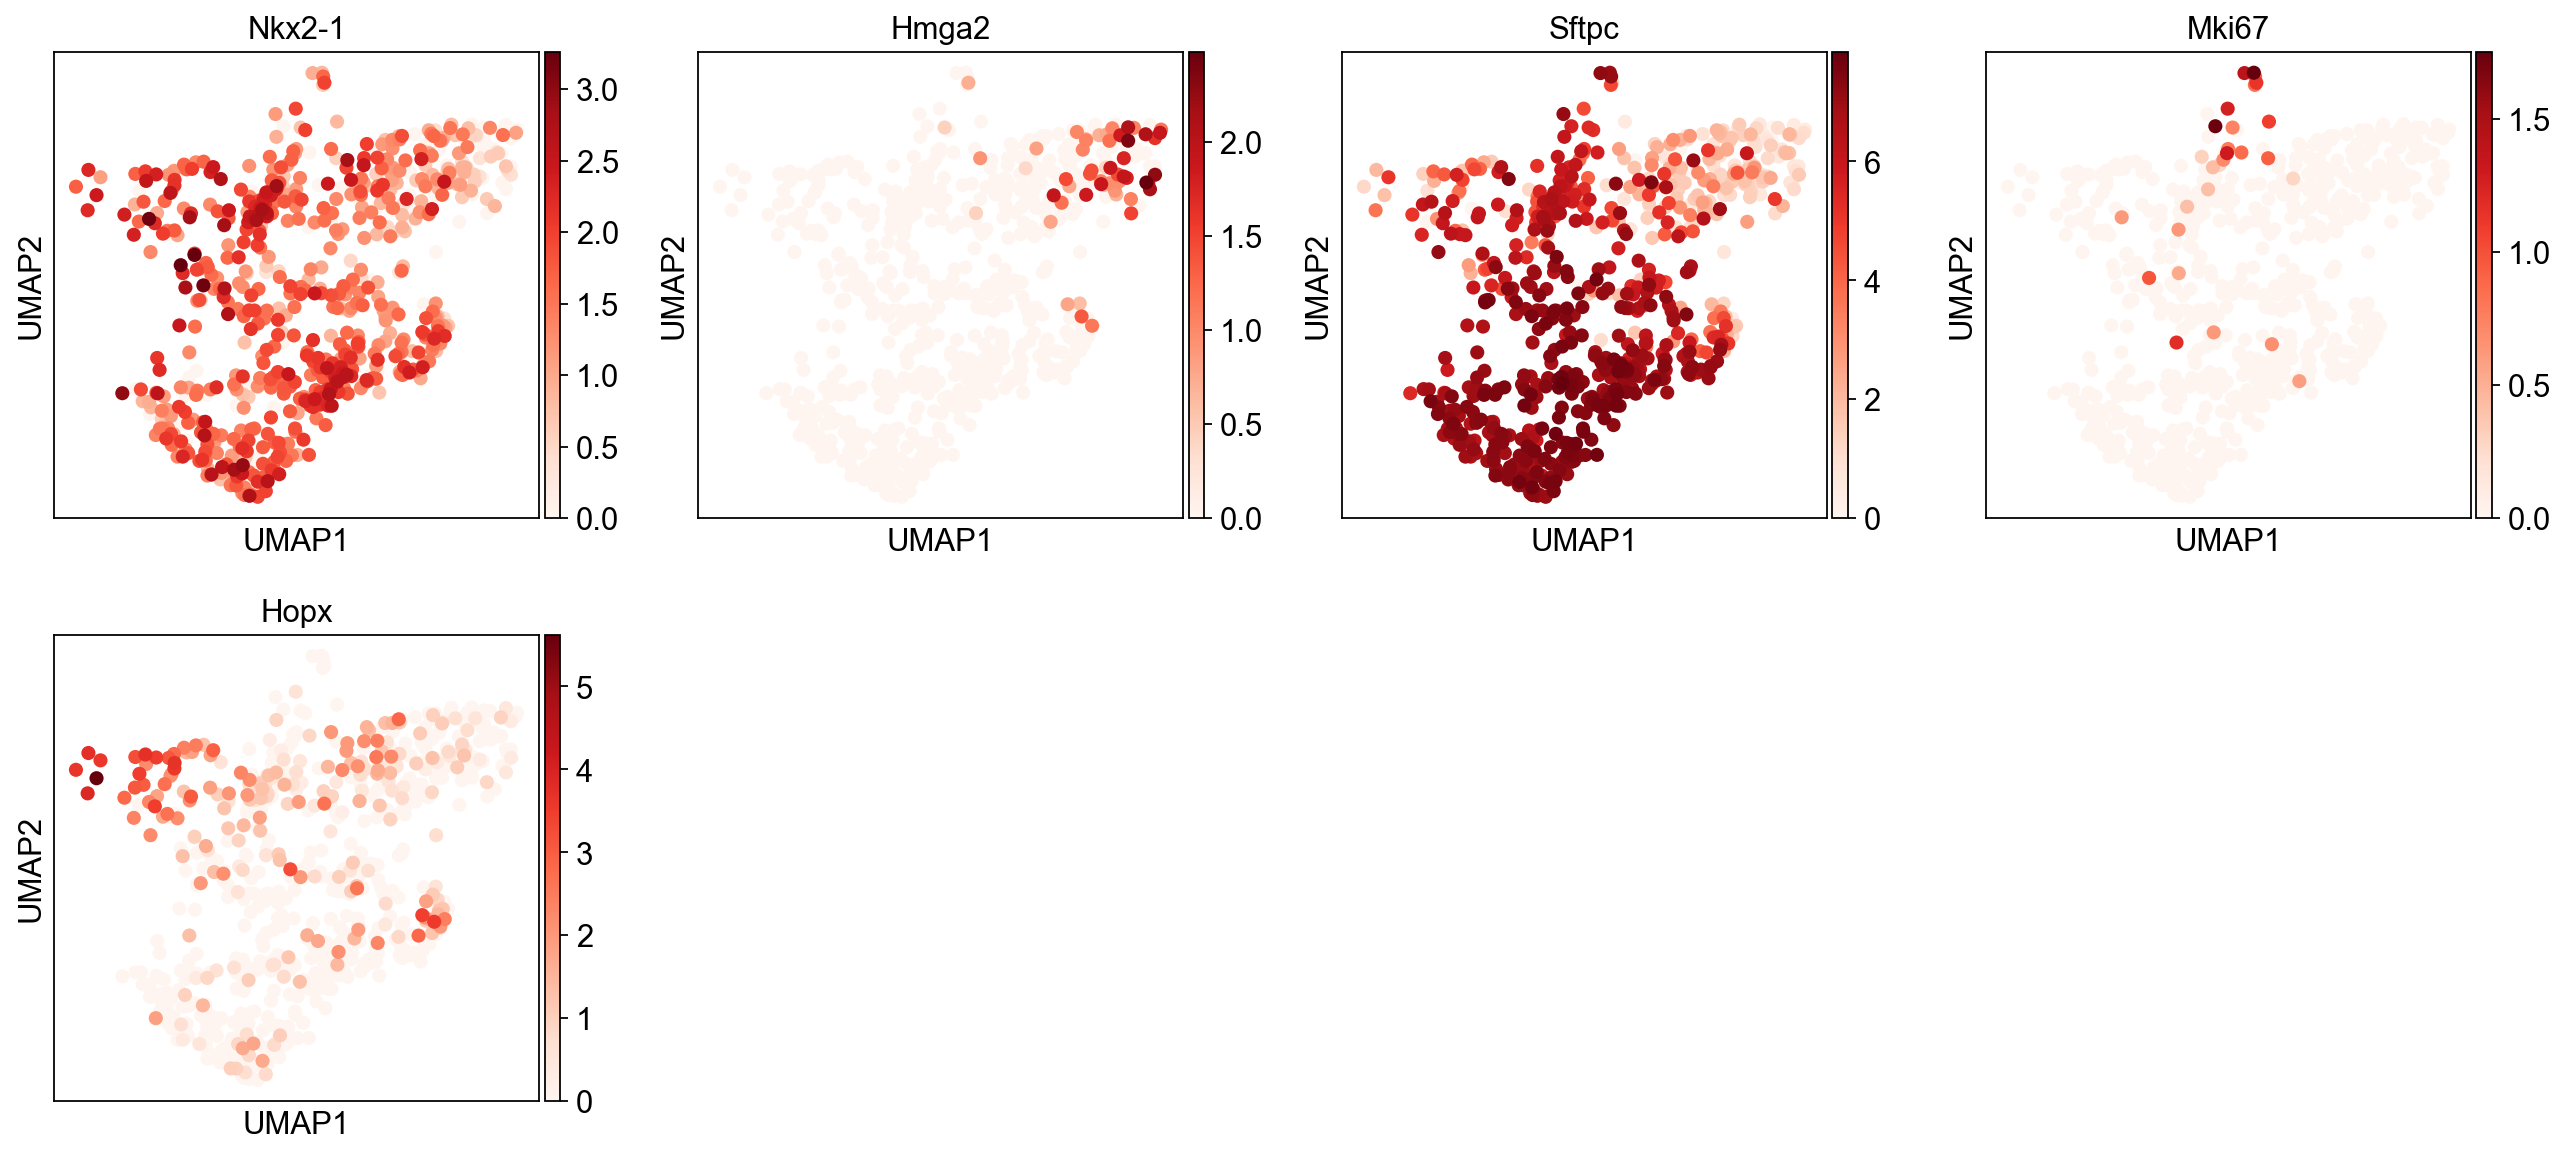

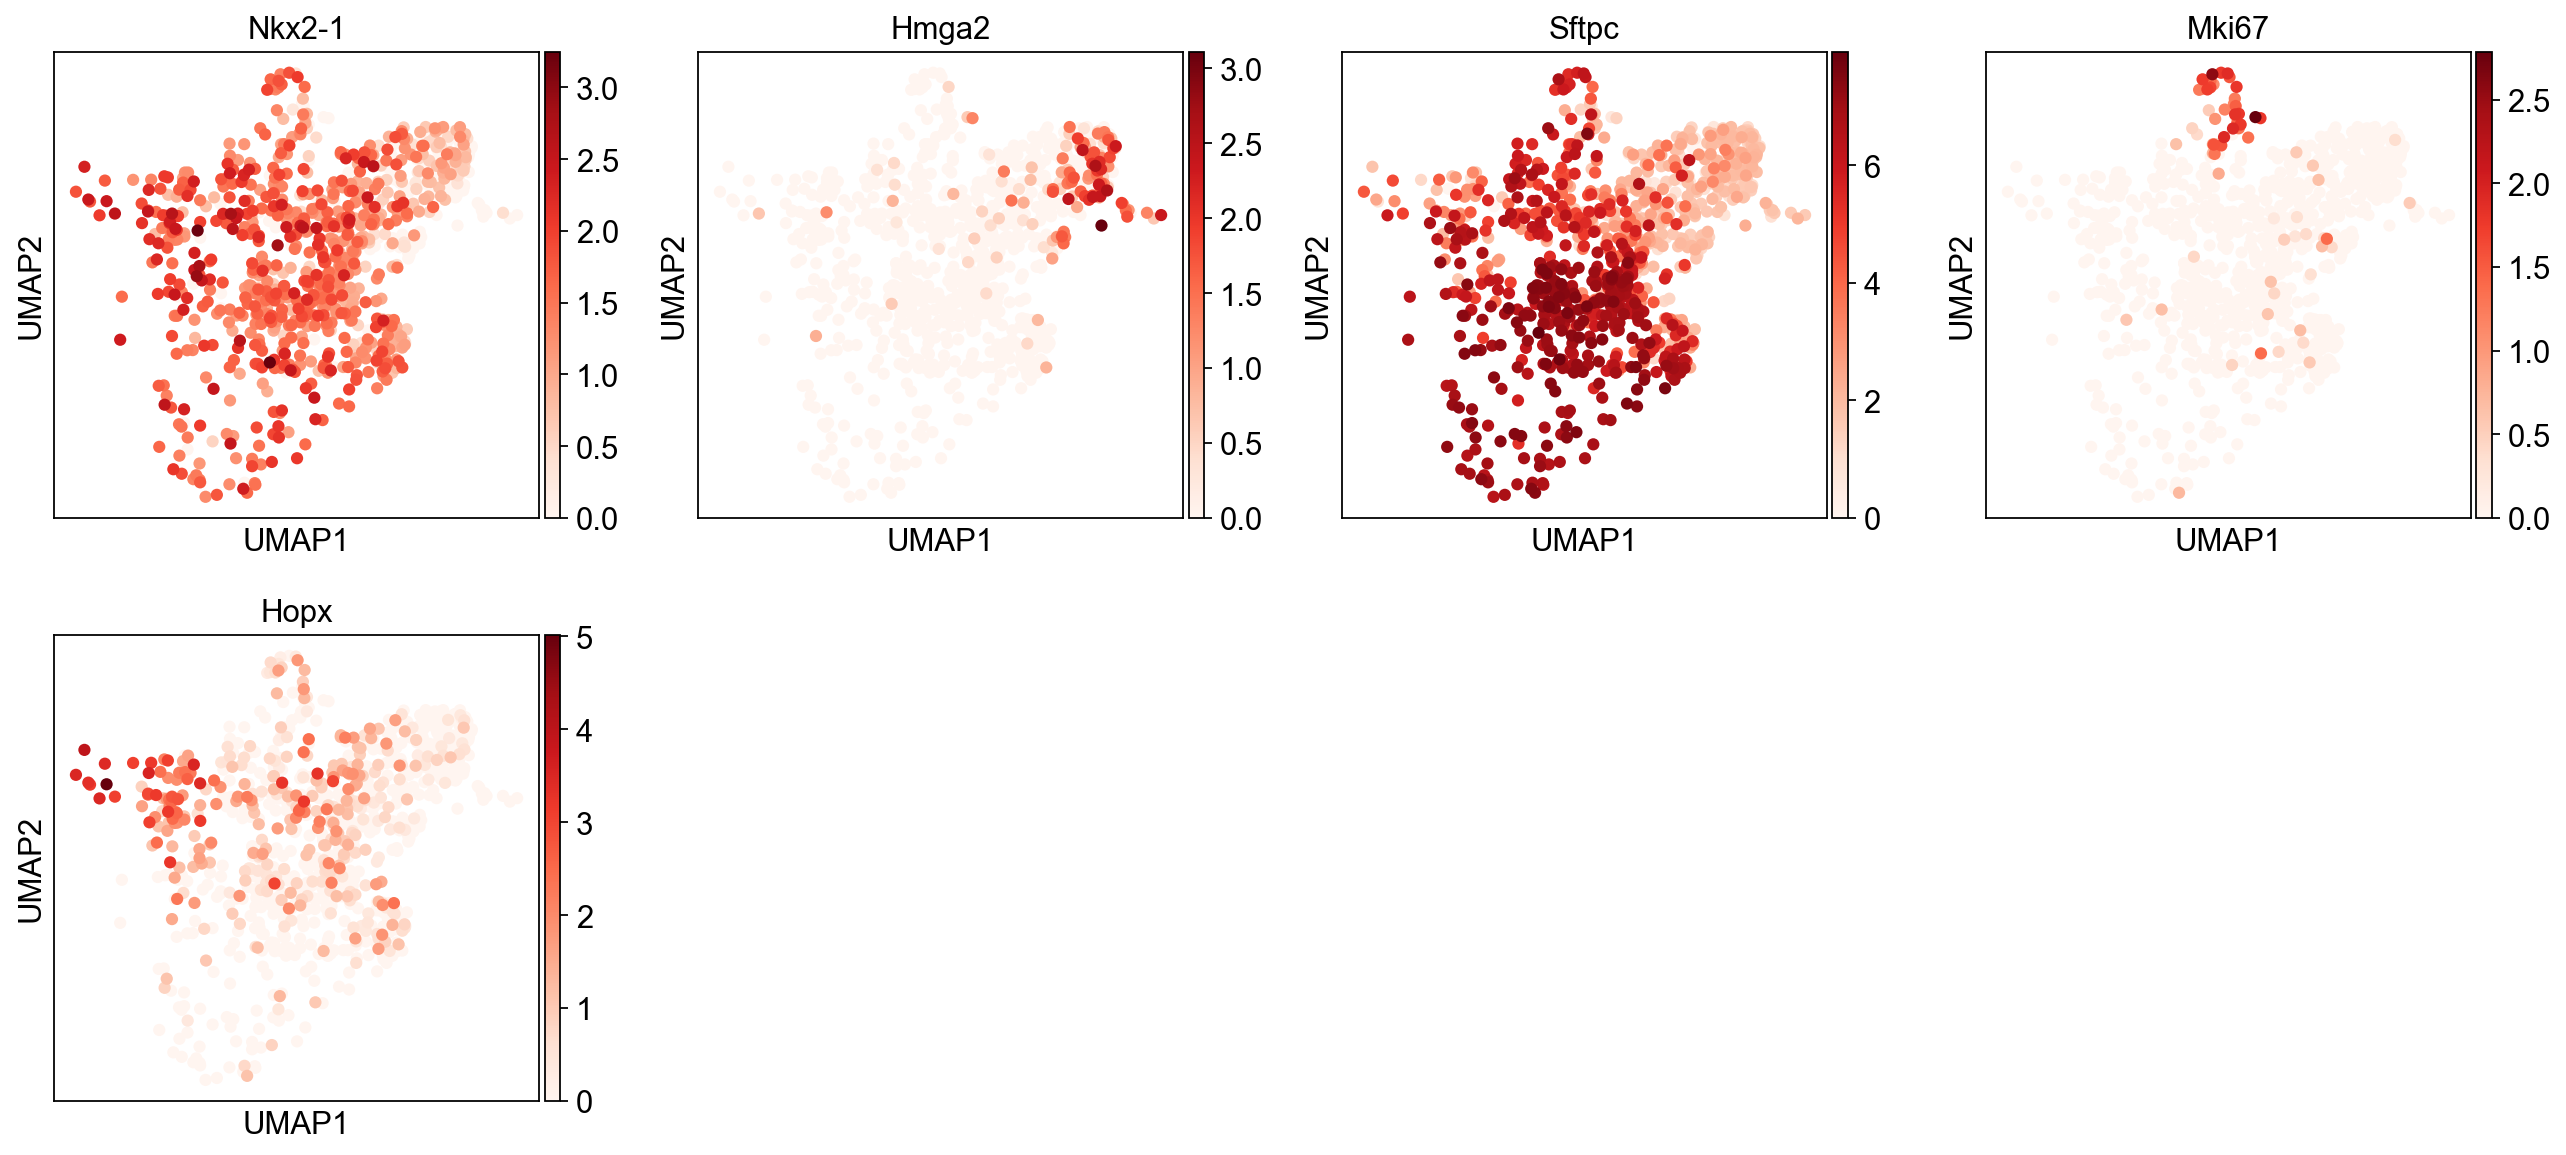

In [62]:
#Markers
sc.pl.umap(adata[adata.obs.Group=='8wk',:],color=['Nkx2-1','Hmga2','Sftpc','Mki67','Hopx'], save='Ext_Data_Fig5e_h_cell type markers-8wk.svg',cmap='Reds')
sc.pl.umap(adata[adata.obs.Group=='14wk',:],color=['Nkx2-1','Hmga2','Sftpc','Mki67','Hopx'], save='Fig2h_Ext_Data_Fig5h_cell type markers-14wk.svg',cmap='Reds')